---
# LG Smart Mirror Image Extraction

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import pprint
import numpy as np
import statistics
import subprocess
import os, shutil
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from time import sleep
from pprint import pprint
from IPython.core.display import HTML

In [2]:
# get video file names
def get_file_list(dirPath):
    file_list = os.listdir(dirPath)
    return file_list

# 비디오 정보 가져오기
def get_video_info(infilename, show_info=True):
    cap = cv2.VideoCapture(infilename)
    if not cap.isOpened():
        print("could not open :", infilename)
        exit(0)
 
    frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
     
    if show_info:
        print('frame : ', frame)
        print('width : ', width)
        print('height : ', height)
        print('fps : ', fps)
    
    return(frame, width, height, fps)

In [3]:
# %%time
# # get video info for debug
# for idx in tqdm(range(df.shape[0])):
#     v = df.iloc[idx]["videoName"]
#     rawVideoPath = os.path.join(rawDirPath, v)
#     l, w, h, f = get_video_info(rawVideoPath, show_info=False)
#     df.iloc[idx]["frame", "width", "height", "fps"] = [l,w,h,f]
# display(df)

In [4]:
errorArr = []
def resizeVideo(df, idx, resizedDirPath):
    global rawDirPath
    global errorArr
    # get original video meta infomation
    videoName = df.iloc[idx]["videoName"]
    rawVideoPath = os.path.join(rawDirPath, videoName) # rawDirPath 전역변수임
    print('[rawVideoPath]:', rawVideoPath)    
    v_length_orig, v_width_orig, v_height_orig, v_fps_orig = get_video_info(rawVideoPath)
    df.iloc[idx]["frame", "width", "height", "fps"] = [v_length_orig, v_width_orig, v_height_orig, v_fps_orig]
    print('---------------------------')
    
    # 리사이징된 비디오 파일 저장 패스
#     resizedVideoPath = os.path.join(resizedDirPath, videoName.replace(' ', '_')) # 띄어쓰기 있으면 나중에 이미지 저장 안됨
    resizedVideoPath = os.path.join(resizedDirPath, videoName) # 띄어쓰기 있으면 나중에 이미지 저장 안됨
    if not os.path.isdir(resizedDirPath): os.makedirs(resizedDirPath)

    # make resized video
    # 'ffmpeg -i "video/190703/AGE20_S-essence cover tx.mp4" -vf scale=-1:960 video/resized/out.mp4'
    if not os.path.isfile(resizedVideoPath):
    # 비디오 스케일 종횡비 결정
        if v_width_orig>1000 or v_height_orig>1000:
            w = int(v_width_orig/2)
            h = int(v_height_orig/2)
    #         scale = "scale=-1:%d"%(h)
            scale = "scale=iw/2:-1"
    #         scale = "scale=%d:%d"%(w,h) # 이거 하면 원본 oritation 정보 잃어버림
            command = ['ffmpeg', '-i', rawVideoPath, '-vf', scale, resizedVideoPath]
        else: # just copy and rename video file
            command = ['cmd', '\/c', 'copy', rawVideoPath, resizedVideoPath]

        print('[Command]: \n', command)
        # 커맨드 실행    
        try:
            cmd_res = subprocess.check_output(command)
            print(cmd_res)
            print('[resizedVideoPath]:', resizedVideoPath)
            v_length, v_width, v_height, v_fps = get_video_info(resizedVideoPath)
        except:
            print('***[Error occured]: ffmpeg', resizedVideoPath)
            errorArr.append([idx, videoName])
    else: 
        print('[Notice]:', resizedVideoPath, 'aleady exist.')
        v_length, v_width, v_height, v_fps = get_video_info(resizedVideoPath)
        
    df.iloc[idx]["resizedName", "width2", "height2"] = [resizedVideoPath, v_width, v_height]
    return (resizedVideoPath, v_width, v_height, v_length)

In [5]:
# 카메라 중심에서의 거리계산 
def calcDist(d, videoWidth, videoHeight):
    cx = videoWidth/2
    cy = videoHeight/2
    x=d[0]; y=d[1]; width=d[2]; height=d[3]
    x_c = x+width/2
    y_c = y+height/2
    dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
    return (d, dist)

# 면적비를 이용해 유효한 사각영역 계산
distArrFilitered_flat=[]  # 센터 거리값 규칙 통과한 것들 flat하게 저장
def mergeRect(rectArr, PreFrameArea, PreRect, ratio=.9,):
    # dist threshold 기준 계산
    distArr = np.array([e[-1] for e in rectArr])
    distDiffArr = distArr[1:] - distArr[:-1]
    if len(rectArr)>2: threshold = statistics.median(distDiffArr)*10 # 20은 사후 검토값이므로 바뀔 수 있음
    else: threshold = math.inf
    
    finRec = (int(videoWidth/2), int(videoHeight/2) ,0,0)
    netArea = videoHeight*videoWidth
    prewidth = PreRect[2]-PreRect[0]
    preheight = PreRect[3]-PreRect[1]
    precalcArea = math.inf
    predist=math.inf
    distArrFilitered_flat.append(0)
    for rect in rectArr:
        rectOnly, dist = rect
        x = min(finRec[0], rectOnly[0])
        y = min(finRec[1], rectOnly[1])
        x2= max(finRec[2], rectOnly[0]+rectOnly[2])
        y2= max(finRec[3], rectOnly[1]+rectOnly[3])
        width = x2-x
        height = y2-y
        
        # 사각 영역 합치는 주요 규칙
        if calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
        if calcArea([x, y, x2, y2])> netArea*0.2: # 초반에 전체면적대비 20%까지는 아래 조건들 무시
#             if dist>predist*1.8: break
            if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
            if calcArea((x,y,x2,y2)) > precalcArea*1.8: break # 합치다가 갑자기 늘어나는 면적 비율 제한 (1.8배 이상시 멈춤)
        
        if calcArea([x, y, x2, y2])> PreFrameArea*1.8: break # 이전 프레임에서 그린 rect보다 갑자기 늘어나는 면적 비율 제한
        if width/prewidth>1.8 or height/preheight>1.8: break # 이전 프레임에서 그린 rect 보다 width, height 가 1.8배 늘어나는 것 제한
        distArrFilitered_flat.append(dist)
        finRec = (x,y,x2,y2)
        precalcArea = calcArea(finRec)
        predist = dist
        # print(calcArea(finRec), netArea*ratio)
    return finRec

# 카메라 중점부터 사각영역 합치기
def mergeByDist(data, PreFrameArea, PreRect, videoWidth, videoHeight, ratio=.8):    
    rects = [calcDist(d, videoWidth, videoHeight) for d in data]
    rects = sorted(rects, key=lambda x: x[-1]) # 중점 거리순으로 소팅
#     rects = np.array(rects)
#     pprint.pprint(rects)
    return mergeRect(rects, PreFrameArea, PreRect, ratio)

# 사각형 면적 계산
def calcArea(rect):
    return (rect[2]-rect[0])*(rect[3]-rect[1])

# 검출영역 저장
def saveImage(frame, detectedRect_orig, videoname, idx):
    width, height = 224, 224
    ratio = height/width
    detectedRect= list(detectedRect_orig)
    
    detectedRect_width = detectedRect[2]-detectedRect[0]
    detectedRect_height = detectedRect[3]-detectedRect[1]
    ratio_detected = detectedRect_height/detectedRect_width
    
#     # reshape image
#     # ratio 맞춰주기
#     if(ratio>ratio_detected): # 가로가 긴 경우
#         upMargin = math.ceil((detectedRect_width - detectedRect_height)/2)
#         downMargin = math.floor((detectedRect_width - detectedRect_height)/2)
#         detectedRect[1] = detectedRect[1] - upMargin
#         detectedRect[3] = detectedRect[3] + downMargin
#     else: # 세로가 긴경우
#         leftMargin = math.ceil((detectedRect_height - detectedRect_width)/2)
#         rightMargin = math.floor((detectedRect_height - detectedRect_width)/2)
#         detectedRect[0] = detectedRect[0] - leftMargin
#         detectedRect[2] = detectedRect[2] + rightMargin
        
#     # 검출영역의 width가 프레임 밖으로 넘어가는 경우 보정
#     if(detectedRect[0]<0):
#         detectedRect[2] = detectedRect[2] - detectedRect[0]
#         detectedRect[0] = 0
#     elif(detectedRect[2]>videoWidth):
#         detectedRect[0] = detectedRect[0] - (videoWidth-detectedRect[2])
#         detectedRect[2] = videoWidth
#     # 검출영역의 height가 프레임 밖으로 넘어가는 경우 보정    
#     if(detectedRect[1]<0):
#         detectedRect[3] = detectedRect[3] - detectedRect[1]
#         detectedRect[1] = 0
#     elif(detectedRect[3]>videoHeight):
#         detectedRect[1] = detectedRect[1] - (videoHeight-detectedRect[3])
#         detectedRect[3] = videoHeight    
        
#     # 마지막으로 화면 넘어간 영역 정리
#     if(detectedRect[0]<0): detectedRect[0] = 0
#     if(detectedRect[2]>videoWidth): detectedRect[2] = videoWidth
#     if(detectedRect[1]<0): detectedRect[1] = 0
#     if(detectedRect[3]>videoHeight): detectedRect[3] = videoHeight            
        
    # 임시 에러 로그 확인용 (정사각형 ratio나오지 않는것 확인)
#     detectedRect_width = detectedRect[2]-detectedRect[0]
#     detectedRect_height = detectedRect[3]-detectedRect[1]
#     ratio_detected = detectedRect_height/detectedRect_width
#     if(ratio_detected != 1): print('*****ratio limit********', detectedRect, ratio_detected)
        
    imgDirOrig = os.path.join(".\\img2", videoname)
    if not os.path.isdir(imgDirOrig): os.makedirs(imgDirOrig)
    imgPathOrig = os.path.join(imgDirOrig, str(videoname)+'_'+str(idx)+'.jpg')    

    imgDir = os.path.join(".\\img2", "temp")
    if not os.path.isdir(imgDir): os.makedirs(imgDir)
    imgPath = os.path.join(imgDir, "temp"+'_'+str(idx)+'.jpg')

    try:
        # trim image
        img_trim = frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]] # y1, y2, x1, x2   
        # image resizing
#         img_modi = cv2.resize(img_trim, (width, height), interpolation=cv2.INTER_CUBIC)
        if calcArea(detectedRect)> 2000:
            if (detectedRect[2]-detectedRect[0])>0 and (detectedRect[3]-detectedRect[1])>0:
                cv2.imwrite(imgPath, img_trim) # 이미지 저장
                os.rename(imgPath, imgPathOrig) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
    except:
        print('[Save Img Error:]', detectedRect_orig, detectedRect)
        
    shutil.rmtree(os.path.join(".\\img2", "temp"))        
    return detectedRect

In [6]:
# %%time
# make all resized video 
# for idx in tqdm(range(df.shape[0])):
#     videoPath, videoWidth, videoHeight, videoLength = resizeVideo(df, idx)

In [7]:
def normalize(frame):
    r = (frame[:,:,2]/225 - 0.485)/0.229
    g = (frame[:,:,1]/225 - 0.456)/0.224
    b = (frame[:,:,0]/225 - 0.406)/0.225
    normarized = np.stack([b,g,r]).transpose([1,2,0])
    return np.clip(normarized*255, 0, 255).astype(np.uint8)

def preprocessVideo(videoPath, OPT_SHOW_IMAGE = True):
    global frame
    global cap
    cap = cv2.VideoCapture(videoPath)
    # 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
    fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)
    # fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
    # fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()
    videoLength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    allData = [] # merged rect 저장하는 배열
    mergedAreas = [] # merged rect 넓이만저장하는 배열
    RectArea = videoHeight*videoWidth # initiation for put preframeArea to mergeRect 
    mergedRect= (0,0,videoWidth,videoHeight)
    # while(1):
    for i in tqdm(range(videoLength)):
        ret, frame = cap.read()
        if(ret):
#             frame = normalize(frame)
            fgmask = fgbg.apply(frame)     
            
#             frame = cv2.GaussianBlur(frame, (5,5), 0) # 가우시안 블러
# #             frame = cv2.GaussianBlur(frame, (11,11), 0) # 가우시안 블러
#             fgmask = fgbg.apply(frame)     
#             fgmask = cv2.medianBlur(fgmask, 5)
        
            edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
            nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

            data = []
            for index, centroid in enumerate(centroids):
                if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                    continue
                if np.any(np.isnan(centroid)):
                    
                    continue

                x, y, width, height, area = stats[index]
                centerX, centerY = int(centroid[0]), int(centroid[1])

                if area > 20: #  컨벡스헐 크기
                    # 유효한 값만 저장
                    data.append(stats[index])

                    if(OPT_SHOW_IMAGE):
                        cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                        cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))

            data = np.array(data)

            # 머지된 사각형 그리기
            mergedRect = mergeByDist(data, RectArea, mergedRect, videoWidth, videoHeight, ratio=.7)
            cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
            RectArea = calcArea(mergedRect)
            mergedAreas.append(RectArea)

            if(OPT_SHOW_IMAGE):
                cv2.putText(frame, str(len(allData))+' RectArea '+str(RectArea), \
                            (30,videoHeight-30),cv2.FONT_HERSHEY_SIMPLEX, 1, (100,0,225), 3) # 프레임 id, 선별영역 넓이
                cv2.circle(frame, (int(videoWidth/2), int(videoHeight/2)), 1, (0,0,0), 6) # 중심점 렌더
                cv2.putText(frame, str(len(data)), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3) # 엣지 컨벡스헐 개수
                # 영역 각각 그리기
                cv2.imshow('bgsub', fgmask)
                cv2.imshow('edge', edge)
                cv2.imshow('frame',frame)


            k = cv2.waitKey(1) & 0xff 
            if k == 27: # esc
                break

            allData.append(mergedRect)  
        else: break

    cap.release()
    cv2.destroyAllWindows()        
    
    return (allData, mergedAreas)

In [8]:
def getStatistics(allData, mergedAreas, showPlot=True):
    global distArrFilitered_flat
    # -------------- 모든 유효한 dist 확인 -------------------
    if(showPlot):
        print("distArrFilitered_flat_median:", statistics.median(distArrFilitered_flat))
        data_dist = np.array(distArrFilitered_flat[:1000])
        plt.figure(figsize=(18,9))
        plt.plot(data_dist[:], label="distArrFilitered_flat")
        plt.plot(data_dist[1:]-data_dist[:-1], label="distArrFilitered_flat diff")
        plt.legend(loc='upper right')
        plt.title("Dist per frame")
        plt.show()

    # --------------- 병합된 면적에서 + - 1.5 sigma 확인 (mean값 사용) -----------------------
    mergedAreas = np.array(mergedAreas)
    diff = abs(mergedAreas[1:] - mergedAreas[:-1])
    diff_median = statistics.median(diff)
    diff_mean = np.sum(diff)/len(diff)

    # 통계량 계산
    var= sum([math.pow(i, 2) for i in mergedAreas]) / len(mergedAreas) - math.pow(mergedAreas.mean(), 2)
    std = math.sqrt(var)
    upperBound = mergedAreas.mean()+ std*1.5
    lowerBound = mergedAreas.mean()- std

    # print("diff_median:", diff_median, ", diff_mean:", diff_mean)

    if(showPlot):
        plt.figure(figsize=(18,9))
        plt.plot(mergedAreas, label="mergedArea")
        plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]), label="mergedArea diff")
        plt.axhline(upperBound, color='r')
        plt.axhline(lowerBound, color='r')
        plt.legend(loc='upper right')
        plt.title("Merged Rect Area")
        plt.show()

    # ------------------ 면적비 차분 통계량 (median값 사용) -------------------------
    mergedAreas = np.array(mergedAreas)
    diff_ratio = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
    diff_ratio_median = statistics.median(diff_ratio)
    diff_ratio_mean = np.sum(diff_ratio)/len(diff_ratio)

    if(showPlot):    
        print('diff_ratio_median:', diff_ratio_median, ', diff_ratio_mean:', diff_ratio_mean)
        plt.figure(figsize=(18,9))
        plt.plot(diff_ratio, label="abs area ratio")
        plt.axhline(diff_ratio_median*7, color='r')
        plt.axhline(diff_ratio_mean, color='g')
        plt.legend(loc='upper right')
        plt.title("Absolute area ratio")
        plt.show()

    # ------------------- 24프레임 단위로 윈도윙 보정 -----------------------
    meanArea24Frame=[]
    referenceAllData=[(0, i) for i in allData]

    #0-23 frame mean
    sum_ = 0
    for i in range(0, 24):
        sum_ += mergedAreas[i]
        meanArea24Frame.append(sum_/(i+1))

    #24-end 24 frame mean
    for i in range(24,len(mergedAreas)):
        sum_ = 0
        for j in range(24):
            sum_ += mergedAreas[i-j]
        meanArea24Frame.append(sum_/24)

    #check Area is much more bigger than mean (in this case twice)
    for i in range(len(mergedAreas)):
        # print(i, meanArea24Frame[i], mergedAreas[i])
        if(mergedAreas[i]/meanArea24Frame[i] > 2):
            # print(i, 'data :',mergedAreas[i], 'mean :',meanArea24Frame[i])
            j = 0
            while(1):
                j += 1
                if(mergedAreas[i-j]/meanArea24Frame[i-j] < 2):
                    referenceAllData[i] = (1,allData[i-j])
                    # print(i, i-j, allData[i], allData[i-j],referenceAllData[i])
                    break
    return (upperBound, lowerBound, diff_ratio_mean, diff_ratio_median, referenceAllData)

In [9]:
def extractImages(videoPath, allData, upperBound, lowerBound, diff_ratio_median, referenceAllData, OPT_SHOW_IMAGE2 = True):
    global cap
    cap = cv2.VideoCapture(videoPath)
    videoname, ext = os.path.splitext(videoPath.split(os.path.sep)[-1])
    print('[Extract Images]:', videoname)
    idx = 0
    shrink_ratio = 0.5 #  abnormal 관측시 5%씩 증감
    shrink_ratio_s = 0.5
    margin = 0.10 # 검출영역 마진
    cnt = 0 # 저장용 프레임 체크용
    save_cnt = 0 # 저장용 파일명 인덱스용
    preRect = []
    detectedRect= [0,0,0,0]
    for i in tqdm(range(videoLength)):
        ret, frame = cap.read()
        if ret:
            mergedRect = allData[idx]
            frame_for_save = frame.copy()
            if bool(preRect):
                # 갑작스럽게 영역의 수축/팽창이 일어나는 경우
                diff_area = calcArea(mergedRect)-calcArea(preRect)
                # 이전 영역대비 수축/팽창 비율 에러 윈도윙 보정 적용, calcArea(preRect)는 0이 아니어야함
                if referenceAllData[idx][0] or (calcArea(preRect)!=0 and diff_ratio_median*7 < abs(diff_area)/calcArea(preRect)):
                    if(referenceAllData[idx][0]):
                        preRect = referenceAllData[idx][1]

                    if diff_area>0: # 갑자기 커지는 경우
                        cv2.putText(frame, str(idx)+' abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                        # 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                        x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                        y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                        x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, videoWidth)
                        y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, videoHeight) 
                        if (x2-x)>(mergedRect[2]-mergedRect[0]):
                            x = mergedRect[0]
                            x2 = mergedRect[2]
                        if (y2-y)>(mergedRect[3]-mergedRect[1]):
                            y = mergedRect[1]
                            y2 = mergedRect[3]

                    else: # 갑자기 작아지는 경우
                        cv2.putText(frame, str(idx)+' abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                        x = preRect[0]*(1-shrink_ratio_s)+mergedRect[0]*shrink_ratio_s
                        y = preRect[1]*(1-shrink_ratio_s)+mergedRect[1]*shrink_ratio_s
                        x2 = preRect[2]*(1-shrink_ratio_s)+mergedRect[2]*shrink_ratio_s
                        y2 = preRect[3]*(1-shrink_ratio_s)+mergedRect[3]*shrink_ratio_s

                    mergedRect = (int(x), int(y), int(x2), int(y2))
                    
                # 마진 넣기
                width = preRect[2]-preRect[0]
                height = preRect[3]-preRect[1]
                detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                                int(max(mergedRect[1]-height*margin/2, 0)),
                                int(min(mergedRect[2]+width*margin/2, videoWidth)),
                                int(min(mergedRect[3]+height*margin/2, videoHeight)) )
                if(calcArea(detectedRect) > upperBound): cv2.putText(frame, 'UPPER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                elif(calcArea(detectedRect) < lowerBound): cv2.putText(frame, 'LOWER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                else: 
                    cnt+=1
                    # n번째마다 저장
                    if(cnt% 10 ==0): 
                        save_cnt += 1
                        savedRect = saveImage(frame_for_save, detectedRect, videoname, save_cnt)
                        cv2.putText(frame, 'Save image', (40, videoHeight), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,0,0), 3)        
                        cv2.rectangle(frame, (savedRect[0], savedRect[1]), (savedRect[2], savedRect[3]), (255, 0, 0), 2)        
    #                     cv2.imshow('frame',frame)
    #                     sleep(0.5)                          
    
            if idx>0: # 첫 프레임 무시
                preRect = mergedRect          

            if OPT_SHOW_IMAGE2:
                cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)
                cv2.imshow('frame',frame)
    #         sleep(0.5)
    #         cv2.imwrite('./img/'+str(videoname)+'_'+str(idx)+'.jpg', frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]]) # 이미지 저장

            k = cv2.waitKey(1) & 0xff 
            if k == 27: # esc
                break

        else: break
        idx += 1    

    cap.release()
    cv2.destroyAllWindows()        

In [9]:
# 윈도는 seprator '\\'로 할 것!! subprocess cmd 에서 에러남 
rawDirPath = ".\\video\\resized"
resizedDirPath = ".\\video\\resized"
cap = None # 에러나면 수동으로 opencv창 릴리즈 해줘야 해서 전역으로 선언

assert os.path.isdir(rawDirPath), "[Error]: '%s' not exist!!"%rawDirPath
video_files = get_file_list(rawDirPath)

df = pd.DataFrame(columns=["videoName","frame","width","height","fps","resizedName","width2","height2"])
df["videoName"] = video_files
display(HTML(df.to_html()))

,videoName,frame,width,height,fps,resizedName,width2,height2
0,1MILLION-PERFUME.MOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4GF-SUPER PURE CLEAR GEL.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6GF+-PROTEOGLYCAN SKIN CARE CREAM.MOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6XCREAM-TREATROMM 6 CREAM.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9WISHES-HYDRA AMPULE SERUM.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A DERMA-PHYS AC PURIFYING FOAMING GEL.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,A2H-CURL UP ESSENCE.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ABLE C_C-미샤M 비비 부머.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL.MOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ACNES-CLEAR_WHITE FOAMING WASH.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
%%time
errors = []
for idx in tqdm(range(0,df.shape[0])):
# for idx in tqdm(range(572,573)):
    videoPath = os.path.join(resizedDirPath, df["videoName"][idx])
    cap = cv2.VideoCapture(videoPath)
    videoLength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    videoWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    videoHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
#     # 비디오 리사이징
#     videoPath, videoWidth, videoHeight, videoLength = resizeVideo(df, idx, resizedDirPath)
#     # 비디오 전처리
#     allData, mergedAreas = preprocessVideo(videoPath, OPT_SHOW_IMAGE = False)
#     # 통계량 추출
#     upperBound, lowerBound, diff_ratio_mean, diff_ratio_median, referenceAllData = getStatistics(allData, mergedAreas, showPlot=False)
#     # 이미지 추출
#     extractImages(videoPath, allData, upperBound, lowerBound, diff_ratio_median, referenceAllData, OPT_SHOW_IMAGE2 = False)
    
#     try-excerpt 문 사용하면 인터럽트도 그냥 넘김... ㅎㅎㅎl
    try:
#         # 비디오 리사이징
#         videoPath, videoWidth, videoHeight, videoLength = resizeVideo(df, idx, resizedDirPath)
        # 비디오 전처리
        allData, mergedAreas = preprocessVideo(videoPath,  OPT_SHOW_IMAGE = False)
        # 통계량 추출
        upperBound, lowerBound, diff_ratio_mean, diff_ratio_median, referenceAllData = getStatistics(allData, mergedAreas, showPlot=False)
        # 이미지 추출
        extractImages(videoPath, allData, upperBound, lowerBound, diff_ratio_median, referenceAllData, OPT_SHOW_IMAGE2 = False)
    except e:
        print("[Error occured]:", idx, videoPath, e)
        errors.append([idx, videoPath])

A Jupyter Widget

A Jupyter Widget

[Extract Images]: 1MILLION-PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 4GF-SUPER PURE CLEAR GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 6GF+-PROTEOGLYCAN SKIN CARE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 6XCREAM-TREATROMM 6 CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 9WISHES-HYDRA AMPULE SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: A DERMA-PHYS AC PURIFYING FOAMING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: A2H-CURL UP ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ABLE C_C-미샤M 비비 부머


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ACNES-CLEAR_WHITE FOAMING WASH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ACNES-DERMA RELIEF ESSENCE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ACURE-THE ESSENTIALS MOROCCAN ARGAN OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ACWELL-AQUA CLINITY CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AESTURA-ATOBARRIER365


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-AURORA ESSENTIAL CREAM


A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-44:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[Extract Images]: AGE20_S-CELL BOUNCE CONCENTRATED SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-CELL BOUNCE CONCENTRATED SERUM


A Jupyter Widget

[Save Img Error:] (466, 124, 776, 385) [466, 124, 776, 385]
[Save Img Error:] (311, 256, 656, 511) [311, 256, 656, 511]
[Save Img Error:] (467, 27, 774, 519) [467, 27, 774, 519]
[Save Img Error:] (466, 50, 772, 469) [466, 50, 772, 469]
[Save Img Error:] (463, 40, 789, 395) [463, 40, 789, 395]
[Save Img Error:] (466, 42, 760, 365) [466, 42, 760, 365]
[Save Img Error:] (462, 21, 847, 354) [462, 21, 847, 354]
[Save Img Error:] (469, 257, 713, 375) [469, 257, 713, 375]
[Save Img Error:] (468, 172, 751, 466) [468, 172, 751, 466]
[Save Img Error:] (464, 141, 804, 524) [464, 141, 804, 524]
[Save Img Error:] (470, 182, 710, 373) [470, 182, 710, 373]
[Save Img Error:] (401, 234, 646, 364) [401, 234, 646, 364]
[Save Img Error:] (459, 168, 652, 313) [459, 168, 652, 313]
[Save Img Error:] (452, 260, 701, 367) [452, 260, 701, 367]
[Save Img Error:] (470, 191, 747, 395) [470, 191, 747, 395]
[Save Img Error:] (468, 59, 731, 428) [468, 59, 731, 428]
[Save Img Error:] (471, 107, 651, 428) [471, 107, 65

A Jupyter Widget

[Extract Images]: AGE20_S-ESSENCE COVER FACT TX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-ESSENCE COVER FACT VX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-essence cover tx


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-HYDRA SYNERGY CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-INTENSE MOISTURE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-REAL CALENDULA EYE_FACE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-ULTRA MOISTURE ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AGE20_S-에센스 쿠션


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE


A Jupyter Widget

[Save Img Error:] (43, 164, 431, 728) [43, 164, 431, 728]
[Save Img Error:] (55, 202, 303, 754) [55, 202, 303, 754]
[Save Img Error:] (67, 374, 316, 716) [67, 374, 316, 716]
[Save Img Error:] (76, 326, 326, 677) [76, 326, 326, 677]
[Save Img Error:] (82, 266, 342, 676) [82, 266, 342, 676]
[Save Img Error:] (61, 321, 331, 680) [61, 321, 331, 680]
[Save Img Error:] (0, 176, 304, 789) [0, 176, 304, 789]
[Save Img Error:] (0, 183, 313, 710) [0, 183, 313, 710]
[Save Img Error:] (27, 182, 309, 739) [27, 182, 309, 739]
[Save Img Error:] (38, 212, 307, 729) [38, 212, 307, 729]
[Save Img Error:] (0, 248, 300, 689) [0, 248, 300, 689]
[Save Img Error:] (0, 251, 303, 662) [0, 251, 303, 662]
[Save Img Error:] (0, 215, 525, 724) [0, 215, 525, 724]
[Save Img Error:] (39, 237, 277, 725) [39, 237, 277, 725]
[Save Img Error:] (32, 261, 301, 639) [32, 261, 301, 639]
[Save Img Error:] (35, 234, 302, 724) [35, 234, 302, 724]
[Save Img Error:] (38, 265, 285, 651) [38, 265, 285, 651]
[Save Img Error:] (58, 2

A Jupyter Widget

[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-Ageless Real Eye ream for Face


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-Aura Secret Toneup Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-Capture Hyaluronic


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-Natural Vita Sun Stick


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-NATURE PLUS SUNSTIC


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-PERFECT DUAL COVER CUSHION 23


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-REAL ACTIVE BLENDING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-REAL ACTIVE PERFECTION CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-REAL GOLD SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-REAL RADIANCE SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-REAL SYNERGY OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-THE REAL EYE CREAM FOR FACE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-ULTIMATE REAL EYE CREAM FOR FACE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AHC-VITAL BLACK SEED TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ALGOLOGIE-RICHESSE DES VAGUES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ALOE VERA-ALOE MOISTURIZING BRIGHT CARE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ALPECIN-COFFEIN SHAMPOO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AMOREPACIFIC-CONTOURE LIFT SKIN DEFINING CREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AMOS-AGE CONTROL SAMPOO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AMOS-ANTI AGING CARE AGE CONTROL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AMOS-REPAIR FORCE THERAPY ESSENTIAL OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ANDALOUS NATURALS-AGE DEFYING NIGHT REPAIR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ANESSA-AQUA BOOSTER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ANNASUI-PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: APIEU-POWER BLOCK SUN BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: APIEU-PURE BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AQUAVELVA-Sensitive 5 in 1 after shave balm


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AQUAXL-MAKE UP FOR EVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ARITAUM-MONO EYES MISS MONO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ARITAUM-MONO EYES PURPLE EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ARITAUM-MONO EYES SOCIAL LITE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ARITAUM-MONO EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ARITAUM-SUGARBALL VELVET CHEEK COLOR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AROMATICA-ALOW MINERAL SUNSCREEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AROMATICA-natural tinted sun cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ASIS TOBE-Hyaluronic Essential Toner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOMY-EVENING CARE PEELING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOMY-SKIN CARE SYSTEM THE FAME LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOMY-Sunscreen SPF 50+ PA+++


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOPALM-MOISTURE BALANCING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOPALM-SOOTHING GEL LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ATOPALM-TOP TO TOE WASH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AVEDA-BOTANICAL KINETICS HYDRORATING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AVEDA-DAMAGE REMEDY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AVEENO-DAILY MOISTURIZING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: AVENE-EAU THERMAL MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: A_PIEU-MINERAL MONO SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: A_PIEU-POWER BLOCK SUN BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BAMBOO-COOL WATER SOOTHING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BANANABOAT-ALOE VERA GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BANILACO-프라임 프라이머 클래식


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BATH_BODY WORKS-HELLO BEAUTIFUL ULTRA SHEA BODY CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BATH_BODY WORKS-PRETTY AS A PEACH BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BATH_BODY WORKS-SUPER SOFT BODY BUTTER SHEA BUTTER COCONUT OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEAUTYMORY-CRYSTAL EXPERT BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-BELIEVE IN TRUTH CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-BERGAMOT HERBAL EXTRACT TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-CREAMY MOISTURIZER DEEP MOIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-MANOLOGY MOISTURIZER AQUA BOMB


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-STRESS SHOOTER CICA BOMB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-THE TRUE CREAM AQUA BOMB


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-THE TRUE CREAM MOISTURIZING BOMB


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BELIF-UV PROTECTOR DAILY SUNSCREEN GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIC-CHA CHA TINT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIC-DANDELION BLUSHER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIC-HIGH BEAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIC-SUGARBOMB


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIC-THE PORE FESSIONAL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIT-DANDELION BLUSH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIT-DANDELION BLUSHER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIT-DANDELION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENEFIT-the porefessional pearl primer


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENIZOIE-MILK BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BENIZOIE-PERFECT SUN PROTECTOR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEVELY HILLS-POLO CLUB JOY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA DAILY BIG TONER SUPER SIZE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA DAILY BIG TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA DAILY BIG TONER


A Jupyter Widget

[Save Img Error:] (118, 300, 333, 621) [118, 300, 333, 621]
[Save Img Error:] (0, 157, 434, 702) [0, 157, 434, 702]
[Save Img Error:] (59, 261, 273, 665) [59, 261, 273, 665]
[Save Img Error:] (0, 138, 447, 830) [0, 138, 447, 830]
[Save Img Error:] (0, 121, 423, 817) [0, 121, 423, 817]
[Save Img Error:] (0, 127, 418, 815) [0, 127, 418, 815]
[Save Img Error:] (0, 108, 433, 805) [0, 108, 433, 805]
[Save Img Error:] (38, 311, 407, 661) [38, 311, 407, 661]
[Save Img Error:] (41, 193, 237, 784) [41, 193, 237, 784]
[Save Img Error:] (70, 272, 351, 629) [70, 272, 351, 629]
[Save Img Error:] (0, 213, 495, 539) [0, 213, 495, 539]
[Save Img Error:] (263, 172, 404, 770) [263, 172, 404, 770]
[Save Img Error:] (50, 361, 293, 683) [50, 361, 293, 683]
[Save Img Error:] (0, 177, 413, 719) [0, 177, 413, 719]
[Save Img Error:] (0, 229, 467, 798) [0, 229, 467, 798]
[Save Img Error:] (89, 265, 351, 702) [89, 265, 351, 702]
[Save Img Error:] (0, 82, 417, 492) [0, 82, 417, 492]
[Save Img Error:] (0, 119, 463

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA DAILY CICA CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA MOIST CREAM SUPER SIZE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA MOIST CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL AQUA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ANGEL KIDS BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ARGAN THERAPY CURLING ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-CLASSIC HAND CREAM INTENSIVE TOTAL RECOVERY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-DISNEY ECO CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ECO DAILY DEFENCE AQUA SUN GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-ECO DAILY DEFENSE SKIN TONE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-HOMME ALL IN ONE FORMULA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-LIFTING MOISTURE THE NUTCRACKER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-OH MY SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-OH MY SUN CREAM


A Jupyter Widget

[Save Img Error:] (45, 112, 396, 824) [45, 112, 396, 824]
[Save Img Error:] (38, 158, 503, 780) [38, 158, 503, 780]
[Save Img Error:] (0, 89, 370, 816) [0, 89, 370, 816]
[Save Img Error:] (144, 95, 540, 777) [144, 95, 540, 777]
[Save Img Error:] (111, 49, 492, 866) [111, 49, 492, 866]
[Save Img Error:] (136, 139, 508, 779) [136, 139, 508, 779]
[Save Img Error:] (94, 122, 478, 744) [94, 122, 478, 744]
[Save Img Error:] (94, 228, 471, 697) [94, 228, 471, 697]
[Save Img Error:] (93, 117, 470, 669) [93, 117, 470, 669]
[Save Img Error:] (63, 145, 468, 826) [63, 145, 468, 826]
[Save Img Error:] (38, 83, 440, 960) [38, 83, 440, 960]
[Save Img Error:] (76, 93, 400, 882) [76, 93, 400, 882]
[Save Img Error:] (107, 104, 400, 825) [107, 104, 400, 825]
[Save Img Error:] (133, 105, 443, 860) [133, 105, 443, 860]
[Save Img Error:] (86, 86, 522, 825) [86, 86, 522, 825]
[Save Img Error:] (75, 188, 540, 673) [75, 188, 540, 673]
[Save Img Error:] (0, 149, 540, 721) [0, 149, 540, 721]
[Save Img Error:] (0

A Jupyter Widget

[Extract Images]: BEYOND-PHYTO AQUA CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-PHYTO AQUA MOITURE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BEYOND-PHYTO AQUA WATER SUN BASE WITH SAP COMPLEX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIO OIL-PURECELLIN OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-ATODERM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-ATODRM PP BAUME ULTRA NOURISHING BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-HYDRABIO CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-HYDRABIO H2O SOLUTION MICELLAIRE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-SENSIBIO H2O MAKEUP REMOVER_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-SENSIBIO H2O MAKEUP REMOVER_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIODERMA-SENSIBIO H2O MAKE_UP REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOSILK-SILK THERAPY ENRICHED ACTION HAIR TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOSILK-SILK THERAPY FAROUK HAIR TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOSILK-SILK THERAPY HAIR TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-Body Refirm Stretch Oil


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-EAU VITAMINEE PERFUMED BODY MILK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-HOMME AQUAPOWER FRESH LOTION IN GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-HOMME AQUAPOWER_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-HOMME AQUAPOWER_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-HOMME FORCE SUPREME INSTANT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BIOTHERM-HOMME FORCE SUPREME SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BLACK BEAN-DASHU BLACK BEAN SUPER HARD SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BLACK-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BLACKMORES-NATURAL VITAMINE E CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BLGARI-POUR HOMME PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-CALYPSO CORAL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-EYE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-FRESH MELON24


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-Long Water Cream Shadow Stick


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-LONG WEAR EVEN FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-POT ROUGE FOR LIPS AND CHEEKS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOBBI BROWN-PRIMER PLUS PROTECTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONABELLA-ROSE WATER TONE UP CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONABELLA-UV PROTECTION TONE UP DAILY SUN BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONABELLA-UV WATER SHIELD SUN BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONAMEDUSA-ALPI SNOW CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONAMEDUSA-FACE WAVE DELETE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONAMEDUSA-FIXER_AMPOULE X MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BONAMEDUSA-ORANGE SKIN DELETE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOOTS-cucumber moisturising lotion for a smooth day


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BORMTREE-GOAT MILK TONE UP CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BOTANITY-FLAVON SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BRING GREEN-ARTEMISIA CALMING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BUBERRY-PERFUME CLASSIC WOMEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BURBERRY-WEEKEND FOR MEN MINIATURE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BURBERY-BRIT SHEER PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BURT_S BEES-COCONUT FOOT CREAME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BVLGARI-AQVA ATLANTIQVE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BVLGARI-BLV POUR HOMME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BVLGARI-OMNIA CORAL FOR WOMEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BVLGARI-OMNIA EAU DE PARFUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: BYREDO-ROSE OF NO MANS_S LAND EAU DE PARFUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CALVIN KLEIN-CK ONE SKIN MOISTURIZER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CALVIN KLEIN-CK2 PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CANMAKE-PERFECT BROWN EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAPTURE-REVITE SOLUTION AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-A CURE 13 TROUBLE CALMING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-A CURE CLARIFYING EMULSION EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-A CURE SKIN SURFACE CLEARING TONE_TEXTURE SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-DOCTOR SOLUTION A CURE CLARIFYING EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-DOCTOR SOLUTION A CURE CLARIFYTING TONER EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-NORDENAU WATER ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAREZONE-NORDENAU WATER TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAROLINA HERRERA-L_EAU EAU FRAICHE 100ML SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAUDALIE-EAU DE BEAUTE BEAUTY ELIXIR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAUDALIE-HUILE DIVINE DIVINE OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CAUDALIE-VINOPERFECT RADIANCE SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CELIMA-DERMA NATURE FRESh BLACKHEAD JOJOBA CLEANSING OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CELL FUSION C-CURE SUNCREEN 100


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CELL FUSION C-LASER SUN SCREEN 100


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CELL FUSION C-LASER SUNSCREEN 100


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CELLSKIN-RENEWAL DUAL EFFECT SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-Centellian Madeca Skin Emulsion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA CREAM POWER BOOSTING FORMULA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-Madeca Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA MICRO SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA SOLUTION ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA TONING ESSENCE TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA UV DEFENCE SUN CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CENTELLIAN24-MADECA UV PROTECTION SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CERACARE-RICH LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CETAPHIL-MOISTURISING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CETAPHIL-MOISTURIZING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CEZANNE-MIX COLOR CHEEK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CFEAD05F-224D_4DE0_AB61_041FDEF2D19C_junghyuk lee


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHAMPS ELYSEES-EAU DE TOILETTE GUERLAIN FOR WOMEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-ALLURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-COCO MADEMISELLE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-COMPLETE CORRECTION CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-DEMAQUILLANT YEUX INTENSE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-INIMITABLE EXTREME MASCARA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-JOUES CONTRASTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-LE BLANC Light Creator Brightening Makeup Base


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-N5 PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-NO.5 EAU DE TOILETTE SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-NO5


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-POWDER BLUSH 86 DISCREATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-ROUGE ALLURE GLOSS 16 EXTASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-ROUGE ALLURE LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHANEL-STYLO EYE LINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-ALBA TROSS DAILY SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-ANTI_WRINKLE PINK OIL IN SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-Control Cream 225g


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-DeAge CRD_Softening Emulsion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-DeAge Red Addition Nutrient Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-DeAge Red Addition Skin Toner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-DeAge Red Edition Eye cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-ROSY VOLUME HEARTZONE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHARMZONE-Top Class Royal Eye Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHICA Y CHICO-ONE SHOT EYE PALETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHLOE-EAU DE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHOSUNGAH-C_T Blend Easy Firming


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CHOSUNGAH-슈퍼 핏 커버 파운데이션 2X 1호


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLAIRE_S KOREA-GUERISSON 9 COMPLEX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLAIRE_S KOREA-GUERISSON MEN_S ONE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLAIRE_S KOREA-GUERISSON SIGNATURE OIL SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLARINS-EXTRA FIRMING NECK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLARINS-SOIN COMPLET


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLEAN AND CLEAR-페이셜 포밍 클렌저


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLEAN-WARM COTTON EAU DE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLEDBEL-24K GOLD SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLEDBEL-FACE LIFT PROGRAM HYDRA POWER LIFTING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLEDBEL-GLUTA POWER WHITENING BOOSTER SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-BLENDED FACE POWER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-CHUBBY STICK MOISTURIZING LIP COLOUR BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-CLARIFYING MOISTURE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-LIP_EYE MAKEUP PALETTE 5X COLOUR SURGE LIPSTICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-MOISTURE SURGE 72HOUR AUTO REPLENISHING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLINIQUE-MOISTURE SURGE INTENSE SKIN FORTIFYING HYDRATOR GEL CREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLIO-ART SHADOW 17 NIGHT BLUE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLIO-KILL BROW AUTO HARD BROW PENCIL 5 GRAY BROWN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLIO-ROUSE HEEL NOODIE BROWN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLIO-SHARP SO SIMPLE WARTERPROOF PENCIL LINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CLIO-VEIGIN KISS SILKUID LIP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-GREEN PROPOLIES PERFECT WRINKLE CORRECTOR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-GREEN PROPOLIS ANTI-OXIDANT AMPULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-Green Propolis Engery Recharging Emulsion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-Green Propolis Intense Firming Creem


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-Green Propolis Skin Hydrating Enhancer


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-HOME ACTIVE SUN BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CNP LABORATORY-Tune-sun care up proection sun


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CONAD-CREMA SOLARE VISO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CONDENSE-BRIGHT AND SOFT LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: COSMEDICS-ULOS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: CREMA IDRALIA-OFFICLNA PROFUMO FARMACEUTLCA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DAISO-GREENTEA NAIL REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DARPHIN-HYDRASKIN RICH CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DARPHIN-INTREAL TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DERMA B-EVERY DAY SUN BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DERMA PLATZ-ACTIVE LAYERED CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DERMALIFT-CENTELLA REPAIR AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DERMATORY-AZULENE HYPOALLERGENIC CICA CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DEWY TREE-ULTRA VITALIZING SNAIL CREAM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DEWY TREE-ULTRA VITALIZING SNAIL CREAM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DEWYTREE-CLEAN LAB HEALTHY FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-ADDICT LIP CLOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-DIORSKIN FOREVER EXTREME CONTROL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-Jabore pearl eau de parfum


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-JADORE WOMEN EAU DE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-LIP GLOW COLOR REVIVER BALM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-LIP GLOW-COLOR REVIVER BALM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-LIP MAXIMIZER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIOR-ROSE EN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIPTYQUE-DO SON


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIPTYQUE-DOSON COLLECTION 34 BOULEVARD SAINT FERMAIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DIPTYQUE-EAU DES SENS HAIR MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DMCK-CLEAN AC CREAM SOOTHING COMBINATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DOCTORCOS-SNOW WHITE WATER GLOW MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DOLCE_GABBANA-LIGHT BLUE_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DOLCE_GABBANA-LIGHT BLUE_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DOLCE_GABBANA-THE ONE GENTLEMAN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DOUBLE RICH-ART DE PEAU HAIR GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DPC-PINK AURA CUSHION SA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.AG PLUS-CICAREPAIR PEELING PAD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.AG PLUS-INTERSIVE DERMA CICA SALVE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-A CLEAR BALANCING MOISTURIZER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-AIRY SKIN UP SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM


A Jupyter Widget

[Save Img Error:] (264, 155, 415, 347) [264, 155, 415, 347]
[Save Img Error:] (195, 127, 523, 480) [195, 127, 523, 480]
[Save Img Error:] (284, 197, 455, 458) [284, 197, 455, 458]
[Save Img Error:] (263, 179, 486, 480) [263, 179, 486, 480]
[Save Img Error:] (182, 175, 487, 480) [182, 175, 487, 480]
[Save Img Error:] (179, 162, 494, 480) [179, 162, 494, 480]
[Save Img Error:] (178, 150, 493, 480) [178, 150, 493, 480]
[Save Img Error:] (185, 174, 434, 478) [185, 174, 434, 478]
[Save Img Error:] (166, 147, 494, 480) [166, 147, 494, 480]
[Save Img Error:] (184, 123, 494, 480) [184, 123, 494, 480]
[Save Img Error:] (171, 138, 486, 480) [171, 138, 486, 480]
[Save Img Error:] (163, 142, 488, 480) [163, 142, 488, 480]
[Save Img Error:] (149, 209, 484, 480) [149, 209, 484, 480]
[Save Img Error:] (157, 228, 466, 480) [157, 228, 466, 480]
[Save Img Error:] (160, 165, 431, 480) [160, 165, 431, 480]
[Save Img Error:] (155, 149, 478, 480) [155, 149, 478, 480]
[Save Img Error:] (155, 151, 466, 480) [

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM_3


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BLACK SNAIL CREAM_4


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BRIGHTENING PEELING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-BRIGHTENING UP SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-FILAGRIN BARRIER CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-GREEN MILD UP SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.G-RED BLEMISH CLEAR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.JART+-BB BEAUTY BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.JART+-HOLY SKIN SOOTHING BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.JART-FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.PEPTI+-CENTELLA TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DR.YOUNG-ANTI PORE ERASER BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: DRG-BLACK SNAIL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: D_ALBA-WHITE TROUBLE FIRST SPREY SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: E45-DERMATOLOGICAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ECLADO-OIL FREE SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ECLADO-Oil Free Sun Cream


A Jupyter Widget

[Save Img Error:] (251, 306, 453, 866) [251, 306, 453, 866]
[Save Img Error:] (103, 137, 495, 913) [103, 137, 495, 913]
[Save Img Error:] (187, 169, 499, 886) [187, 169, 499, 886]
[Save Img Error:] (55, 127, 477, 949) [55, 127, 477, 949]
[Save Img Error:] (200, 137, 441, 865) [200, 137, 441, 865]
[Save Img Error:] (0, 160, 460, 960) [0, 160, 460, 960]
[Save Img Error:] (110, 196, 627, 878) [110, 196, 627, 878]
[Save Img Error:] (241, 246, 563, 669) [241, 246, 563, 669]
[Save Img Error:] (96, 55, 548, 960) [96, 55, 548, 960]
[Save Img Error:] (205, 231, 437, 780) [205, 231, 437, 780]
[Save Img Error:] (217, 241, 494, 802) [217, 241, 494, 802]
[Save Img Error:] (200, 81, 519, 960) [200, 81, 519, 960]
[Save Img Error:] (232, 196, 521, 782) [232, 196, 521, 782]
[Save Img Error:] (188, 180, 614, 870) [188, 180, 614, 870]
[Save Img Error:] (167, 124, 628, 921) [167, 124, 628, 921]
[Save Img Error:] (222, 81, 477, 921) [222, 81, 477, 921]
[Save Img Error:] (211, 168, 637, 763) [211, 168, 637,

A Jupyter Widget

[Extract Images]: ECLADO-Real White eRaser Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ECLADO-regene Blemish Balm


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EDP-DOMINIQUE ROPION GERANIUM TOUR MONSIEUR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ELASTINE-Silk repair recovery oil essence


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ELENSILIA CPP-PLACENTA 80 MILLESIS CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ELENSILIA-ESCARGOT ORIGINAL REPAIR BEE VENOM MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ELIZABETH ARDEN-EIGHT HOUR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ENJOY-Perfect Daily Sun Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ENPRANI-ONE TOUCH SUN POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESCADA-HOMME ESSENCE EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESPOIR-PRO TAILOR FOUNDATION MEDIUM2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESPOIR-PRO TAILOR FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESPOIR-PRO TAILOR LIQUID FOUNDATION EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-Advanced Night Repair Synchronized Complex II


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-ADVANCED NIGHT REPAIR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-ADVANCED NIGHT REPAIR


A Jupyter Widget

[Save Img Error:] (32, 136, 260, 554) [32, 136, 260, 554]
[Save Img Error:] (46, 125, 291, 534) [46, 125, 291, 534]
[Save Img Error:] (81, 197, 258, 450) [81, 197, 258, 450]
[Save Img Error:] (66, 228, 253, 390) [66, 228, 253, 390]
[Save Img Error:] (0, 119, 197, 475) [0, 119, 197, 475]
[Save Img Error:] (49, 115, 192, 480) [49, 115, 192, 480]
[Save Img Error:] (48, 99, 216, 623) [48, 99, 216, 623]
[Save Img Error:] (0, 96, 215, 626) [0, 96, 215, 626]
[Save Img Error:] (89, 223, 244, 416) [89, 223, 244, 416]
[Save Img Error:] (86, 181, 257, 419) [86, 181, 257, 419]
[Save Img Error:] (97, 146, 252, 386) [97, 146, 252, 386]
[Save Img Error:] (62, 135, 260, 399) [62, 135, 260, 399]
[Save Img Error:] (22, 77, 261, 532) [22, 77, 261, 532]
[Save Img Error:] (130, 198, 283, 445) [130, 198, 283, 445]
[Save Img Error:] (69, 140, 272, 463) [69, 140, 272, 463]
[Save Img Error:] (26, 32, 246, 500) [26, 32, 246, 500]
[Save Img Error:] (48, 160, 246, 524) [48, 160, 246, 524]
[Save Img Error:] (0, 21

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-ADVANCED NIGHT REPAIR_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-DOUBLE WEAR STAY IN PLACE MAKEUP_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-DOUBLE WEAR STAY IN PLACE MAKEUP_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-Double Wear Stay_in_Place Makeyp


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-DOUBLE WEAR ZERO MASCARA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-DOUBLE WEAR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-PURE COLOR CRYSTAM LIPSTIC 01 CRYSTAL BABY CREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-PURE COLOR LOVE LIPSTICK_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-PURE COLOR LOVE LIPSTICK_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTEE LAUDER-SUMPTUOUS KNOCKOUT MASCARA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTETICA-HYDRA MULTI THERAPY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ESTHEMORE-컬링 에센스 2X


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ETUDE HOUSE-DOUBLE LASTING FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ETUDE HOUSE-GLOW ON BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ETUDE HOUSE-PLAY COLOR EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ETUDE HOUSE-SOON JUNG MOIST RELIEF ALL IN ONE GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ETUDE HOUSE-UV DOUBLE CUT SUN GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EUBOS-HAUT RUHE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EUCERIN-DERMATOCLEAN CLARIFYING TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EUCERIN-HYALURON FILLER VOLUME LIFT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EVAS-LEMONADE MOISTURE HAND CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EVOLUDERM-EAU MICELLAIRE CLEANSING WATER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: EXCELMAKE-FIVE LAYERS SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FACE IT-RADIANCE MAKEUP BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FAIRY TALES-ROSEMARY HAIR SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FAISIES-MAYBELINE VOLUME EXPRESS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FERRARI-UOMO PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FIRST AID BEAUTY-ULTRA REPAIR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FIRSTLAB-PROBIOTIC REVERSE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FIXX-ALL DAY GLOW MAKEUP SETTING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FO ARUM-NATURAL BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FRESH-SUGAR FACE POLISH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FROM NATURE-ALOEVERA PERFECT SUN BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FROM NATURE-COLLAGEN HYDRO HONEY ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FRUIT OF THE EARTH-ALOE VERA 100_ GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: FUERAIN-METEORITES TRAVEL TOUCH FACE POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: F_CO-BANILA CO PRIME PRIMER BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GD3.4-HAIR ENHANCER AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GINGER-LAURA MERCIER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GIORGIO ARMANI-ACQUA DI GIO POUR HOMME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GIORGIO ARMANI-LASTING SILK UV FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GIORGIO ARMANI-LASTING SILK UV FOUNDATION


A Jupyter Widget

[Save Img Error:] (319, 41, 593, 525) [319, 41, 593, 525]
[Save Img Error:] (219, 39, 759, 459) [219, 39, 759, 459]
[Save Img Error:] (255, 50, 813, 460) [255, 50, 813, 460]
[Save Img Error:] (256, 79, 811, 455) [256, 79, 811, 455]
[Save Img Error:] (196, 0, 800, 469) [196, 0, 800, 469]
[Save Img Error:] (256, 0, 802, 463) [256, 0, 802, 463]
[Save Img Error:] (199, 125, 791, 520) [199, 125, 791, 520]
[Save Img Error:] (192, 0, 782, 492) [192, 0, 782, 492]
[Save Img Error:] (286, 0, 793, 464) [286, 0, 793, 464]
[Save Img Error:] (213, 0, 782, 454) [213, 0, 782, 454]
[Save Img Error:] (268, 23, 741, 436) [268, 23, 741, 436]
[Save Img Error:] (264, 21, 696, 423) [264, 21, 696, 423]
[Save Img Error:] (152, 0, 769, 438) [152, 0, 769, 438]
[Save Img Error:] (297, 60, 629, 426) [297, 60, 629, 426]
[Save Img Error:] (281, 78, 730, 446) [281, 78, 730, 446]
[Save Img Error:] (150, 0, 775, 479) [150, 0, 775, 479]
[Save Img Error:] (153, 66, 798, 474) [153, 66, 798, 474]
[Save Img Error:] (136, 67

A Jupyter Widget

[Extract Images]: GIORGIO ARMANI-LIP MAGNET


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOODAL-DOUBLE BRIGHT DDAY AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOODAL-DOUBLE BRIGHT WHITENING C AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOODAL-GREEN TANGERINE VITA C DART SPOT SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOODAL-GREEN TAUGERINE VITA C CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOODAL-PREMIUM SNAIL TONE UP CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GOONGBE-FRESS SUN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-AFTER SUN CLEANSING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-INTENSIVE SUN BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-KIDS FACIAL LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-MY KIDS KIDS LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-야외놀이 선로션 SPF PA 45


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREEN FINGER-야외놀이 선크림


A Jupyter Widget

A Jupyter Widget

[Extract Images]: GREENFINGER-ULTRA LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-GOKU JYUN PERFECT GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-ROHTO HADALABO GOKUJUN HYALURONIC LOTION MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-SHIRO JYUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-SHIRO JYUN Lotion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-SHIRO JYUN MILK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HADALABO-기와미츠 유무워터 하또무기_비타


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAIR PLUS-OH FRESH DEEP HERBAL SCALP CLEANSING SHAMPOO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAIR PLUS-VELVET PROTEIN BOND NUTRI INJECTION AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HANGYEOL-SUN PROTECTOR WITH BLISS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HANSKIN-Caviar Gold BB Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HANYUL-PURE ARTEMISIA WATERY CALMING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAPPY BATH-AQUA MOISTURE SUN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAPPY BATH-Deep Cleansing Form


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAPPY BATH-FACIAL YOGURT FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAPPY BATH-PERFECT SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HAZZYS MEN-RULE420 WHITENING SUN ALL IN ONE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HEALTH REVOLUTION_S-HERBAL FACE FOOD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HENVX-INSTANT HARI PLUS POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-AGE AWAY VITALIZING NIGHT MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-AGE REVERSE CUSHION C13


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION 21


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION_3


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLACK FOUNDATION WEIGHTLESS COVER FIT FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-BLINDNESS BLACK CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-HD PERFECT FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-MAGIC STARTER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-MAKE UP FIXER ALL DAY FITTING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-MAKE UP FIXER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-SHADOW HOLIC 4D


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-SIGNIA CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-SUN MATE EXCELLENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-SUN MATE PROTECTOR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HERA-UV MIST CUSHION COVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HEROINE MAKE-SMOOTH LIQUID EYELINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HIMALAYA HERBALS-REVITALIZING NIGHT CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HIMALAYA-LIP BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HIMALAYA-NOURISHING SKIN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HIMALAYA-NOURISHING SKIN CREAM


A Jupyter Widget

[Save Img Error:] (0, 192, 540, 877) [0, 192, 540, 877]
[Save Img Error:] (0, 196, 540, 844) [0, 196, 540, 844]
[Save Img Error:] (0, 217, 540, 803) [0, 217, 540, 803]
[Save Img Error:] (11, 207, 540, 741) [11, 207, 540, 741]
[Save Img Error:] (24, 205, 540, 714) [24, 205, 540, 714]
[Save Img Error:] (15, 203, 540, 745) [15, 203, 540, 745]
[Save Img Error:] (16, 176, 540, 810) [16, 176, 540, 810]
[Save Img Error:] (39, 235, 512, 728) [39, 235, 512, 728]
[Save Img Error:] (18, 138, 540, 831) [18, 138, 540, 831]
[Save Img Error:] (0, 155, 540, 817) [0, 155, 540, 817]
[Save Img Error:] (0, 264, 540, 748) [0, 264, 540, 748]
[Save Img Error:] (0, 156, 540, 701) [0, 156, 540, 701]
[Save Img Error:] (0, 199, 540, 731) [0, 199, 540, 731]
[Save Img Error:] (0, 155, 540, 735) [0, 155, 540, 735]
[Save Img Error:] (0, 177, 540, 733) [0, 177, 540, 733]
[Save Img Error:] (0, 177, 522, 826) [0, 177, 522, 826]
[Save Img Error:] (0, 177, 540, 730) [0, 177, 540, 730]
[Save Img Error:] (0, 174, 540, 730)

A Jupyter Widget

[Extract Images]: HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HOLIKA HOLIKA-PEACE MATCHING SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: HUGO-Element eau de toilette


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IDIUOMO-SKIN TYPE TESTATO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ILDONG-Probiotic Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ILLI-TOTAL AGING CARE BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ILLIYOON-CERAMIDE ATO CONCENTRATE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ILLIYOON-CERAMIDE ATO CONCENTRATE CREAM


A Jupyter Widget

[Save Img Error:] (359, 405, 1080, 1496) [359, 405, 1080, 1496]
[Save Img Error:] (266, 318, 807, 1162) [266, 318, 807, 1162]
[Save Img Error:] (213, 398, 988, 1538) [213, 398, 988, 1538]
[Save Img Error:] (335, 749, 909, 1653) [335, 749, 909, 1653]
[Save Img Error:] (375, 493, 927, 1446) [375, 493, 927, 1446]
[Save Img Error:] (353, 928, 948, 1618) [353, 928, 948, 1618]
[Save Img Error:] (367, 735, 860, 1610) [367, 735, 860, 1610]
[Save Img Error:] (417, 443, 947, 1467) [417, 443, 947, 1467]
[Save Img Error:] (381, 446, 932, 1544) [381, 446, 932, 1544]
[Save Img Error:] (345, 439, 880, 1516) [345, 439, 880, 1516]
[Save Img Error:] (343, 441, 869, 1423) [343, 441, 869, 1423]
[Save Img Error:] (353, 359, 856, 1611) [353, 359, 856, 1611]
[Save Img Error:] (354, 382, 858, 1611) [354, 382, 858, 1611]
[Save Img Error:] (331, 448, 898, 1258) [331, 448, 898, 1258]
[Save Img Error:] (352, 372, 854, 1610) [352, 372, 854, 1610]
[Save Img Error:] (357, 337, 897, 1607) [357, 337, 897, 1607]
[Save 

A Jupyter Widget

[Extract Images]: ILLIYOON-PROBIOTICS SKIN BARRIER ESSENCE DROP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IMFROM-MUGWORT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNESFREE-MY EYE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-ALOE REVITAL SOOTHING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-APPLE SEED LIB _ EYE MAKE UP REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-APPLE SEED LIP AND EYE MAKEUP REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-BIJA TROUBLE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-BLUEBERRY REBALANCING SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-DERMA FORMULA PEELING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-eco nail remover


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-EXTREME UV PROTECTION CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-FOREST FOR MEN FRESH CLEANSING FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-forest for men fresh skin Jeju phytoncide complex


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-FOREST FOR MEN PORE CARE ALL IN ONE ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-green barley Peeting Toner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-green tea lotion for men


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-GREEN TEA SEED ESSENC IN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-green tea seed serum


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-Green tea Skin for Men


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-INTENSIVE LONG LASTIN SUNSCREEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-JEJU CHERRY BLOSSOM SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-JEJU ORCHID SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-JEJU SPARKLING MOISTURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-MOISTURIZING OIL SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-MY DROP WATER MOISTURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-NAIL REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-OLIVE REAL CLEANSING FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-olive real essential oil Ex


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-PERFECT 9 REPAIR CREAM EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-PERFECT 9 REPAIR EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-PERFECT UV PROTECTION CREAM(1)


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-perfect uv protection cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-PERFECT9 REPAIR LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-SOYBEAN ENERGY NECK CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-SOYBEAN ENERGY OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-soybean energy oil


A Jupyter Widget

[Save Img Error:] (0, 62, 423, 943) [0, 62, 423, 943]
[Save Img Error:] (0, 0, 419, 900) [0, 0, 419, 900]
[Save Img Error:] (0, 0, 409, 896) [0, 0, 409, 896]
[Save Img Error:] (0, 0, 403, 811) [0, 0, 403, 811]
[Save Img Error:] (0, 113, 427, 825) [0, 113, 427, 825]
[Save Img Error:] (0, 60, 458, 820) [0, 60, 458, 820]
[Save Img Error:] (0, 43, 442, 908) [0, 43, 442, 908]
[Save Img Error:] (0, 62, 436, 814) [0, 62, 436, 814]
[Save Img Error:] (0, 0, 476, 815) [0, 0, 476, 815]
[Save Img Error:] (0, 0, 540, 708) [0, 0, 540, 708]
[Save Img Error:] (0, 0, 540, 641) [0, 0, 540, 641]
[Save Img Error:] (81, 221, 326, 710) [81, 221, 326, 710]
[Save Img Error:] (22, 171, 337, 685) [22, 171, 337, 685]
[Save Img Error:] (0, 0, 418, 775) [0, 0, 418, 775]
[Save Img Error:] (86, 64, 353, 529) [86, 64, 353, 529]
[Save Img Error:] (85, 130, 403, 807) [85, 130, 403, 807]
[Save Img Error:] (84, 68, 488, 806) [84, 68, 488, 806]


A Jupyter Widget

[Extract Images]: INNISFREE-TRUECARE NON_NANO SUNSCREEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-마이 블러셔 햇살 가득 장미


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNISFREE-비비드 후르츠 틴트 물 먹은 체리


A Jupyter Widget

A Jupyter Widget

[Extract Images]: INNODERM-INNODERM CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-AIR CUSHION MOISTURE RESTING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-BIO ESSENCE INTENSIVE CONDITIONING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-BIO NIGHT MASK INTENSIVE RECHARGING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-CC


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-DERMA REPAIR CICA CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-DERMA REPAIR CLEAN SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-EYEBROW AUTO PENCIL EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-LIVE LIFT EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-LIVE LIFT SOFTENER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-MOIST CLEANSING OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-PERFECT SKIN BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IOPE-UV SHIELD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IPKN MAN-TOWER ACTIVE(LITE) ALL IN ONE PRO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-365 SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-Heating Drop Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-HOMME SKIN CARE AFTERSHAVE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-HYDRO LIFTING TREATMENT REPAIR SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-IDEAL RINGER MEDIHYALON DROP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-MX_II PLATINUM ULTRA MOISTURE EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-NOX LAB EYE CREAM RETINOL _ MOISTURE LIPOSOME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-Powdery Cotton Sun Stick


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-Tervina LX Homme Regenerating Torner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-THE PRESTIGE RE ACTIVE CONCENTRATING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-THE PRESTIGE RE ACTIVE CONCENTRATING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-THE PRESTIGE RE ACTIVE HYDRATING EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-UV SUN PRO BEAUTY SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA KNOX-X2D2 PORE CORRECTOR SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISA NOX-POWDERY COTTON SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISOI-BR MOISTURIZIP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ISOI-PORE TIGHTENING FRESH GEL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IT_S SKIN-COLLAGEN NUTRITION EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IT_S SKIN-IT_S TOP BY ITALY SATIN LIP PENCIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: IT_S SKIN-POWER 10 FORMULA WR FACE _ BODY OIL MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: I_M MEME-I_M SHADING PALETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: J.ESTINA-PEARL FECTION FLOW FIXER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JAMINKYUNG-CARACOL ALL IN ONE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JIMMY CHOO-BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JIMMY CHOO-EAU DE TOILETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JIMMY CHOO-오드트휠렛


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JJHO DERMA-D MOISTURE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-BLACKBERRY AND BAY COLOGNE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-BLOSSOM AND HONEY COLOGNE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-ENGLISH PEAR _ FREESIA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-LACKBERRY_BAY COLOGNE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-OSMANTHUS BLOSSOM COLOGNE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JO MALONE-WOOP SAGE _ SEA SALT COLOGNE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JOHN VARVATOS-ARTISAN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JOHN VARVATOS-ARTISAN_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: JUNGSAEMMOOL-ARTIST CONCEALER PALETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: J_COCEU-PEPTIDE VOLUME ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KAMILL-HAND _ NAGELCREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: Kamill-Hand _ Nail Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KAMILL-HAND_NAGELCREME CLASSIC


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KAMILL-HAND_NAIL CREAM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KAMILL-HAND_NAIL CREAM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KAMILLE-HANDCREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KARADIUM-DEEP PORE CLEAN CLEANSING WATER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KATE-BROWN SHADE EYES_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KATE-BROWN SHADE EYES_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KATE-DESIGNING EYE BROW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KATE-POWDERIESS LIQUID FOR COVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KENNETH COLE-BLACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KENZO-LEAU KENZO POUR HOMME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: Kerastate-Nutritive Nectar Thermique


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-CALENDUAL HERBAL EXTRACT ALCOHOL FREE TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-CALENDULA DEEP CLEANSING FOAMING FACE WASH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-CLEARLY CORRECTIVE DARK SPOT SOLUTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-FACIAL FUEL ENERGIZING TONIC FOR MAN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-FACIAL FUEL ENERGIZING TONIC FOR MEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-LIP BALM CRANBERRY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-MID NIGHT RECOVERY CONCENTRATE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-POWERFUL STRENGTH LINE REDUCING CONCENTRATE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-PRECISION LIFTING _ PORE TIGHTENING CONCENTRATE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-TURMERID _ CRANBERRY SEED ENERGIZING RADIANCE MASQUE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA FACIAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA FACIAL CREAM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA FACIAL CREAM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA FACIAL CREAM_3


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA FACIAL TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KIEHL_S-ULTRA LIGHT DAILY UV DEFENSE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISS ME-EYELINER BLACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISS ME-HEAVY ROTATION COLORING EYEBROW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISS ME-HEROINE MAKE MASCARA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISS ME-HEROINE MAKE SMOOTH LIQUID EYELINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISSME-HEAVY ROTATION COLORING EYRBROW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISSME-HEROINE MAKE SMOOTH LIQUID EYE LINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISSME-HEROINE MAKE SMOOTH LIQUID EYELINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: KISSME-HEROINE MAKEUP SMOOTHING EYELINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA RECHE POSAY-LIPIKAR LAITLOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-EFFACLAR DUO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-EFFACLAR DUO


A Jupyter Widget

[Save Img Error:] (75, 4, 403, 854) [75, 4, 403, 854]
[Save Img Error:] (163, 18, 404, 917) [163, 18, 404, 917]
[Save Img Error:] (182, 52, 360, 853) [182, 52, 360, 853]
[Save Img Error:] (97, 40, 387, 902) [97, 40, 387, 902]
[Save Img Error:] (171, 82, 414, 811) [171, 82, 414, 811]
[Save Img Error:] (150, 93, 426, 748) [150, 93, 426, 748]
[Save Img Error:] (181, 91, 428, 875) [181, 91, 428, 875]
[Save Img Error:] (187, 65, 419, 926) [187, 65, 419, 926]
[Save Img Error:] (187, 56, 424, 892) [187, 56, 424, 892]
[Save Img Error:] (91, 75, 429, 899) [91, 75, 429, 899]
[Save Img Error:] (169, 32, 430, 897) [169, 32, 430, 897]
[Save Img Error:] (174, 67, 430, 816) [174, 67, 430, 816]
[Save Img Error:] (226, 169, 433, 794) [226, 169, 433, 794]
[Save Img Error:] (106, 185, 391, 816) [106, 185, 391, 816]
[Save Img Error:] (67, 400, 427, 631) [67, 400, 427, 631]
[Save Img Error:] (249, 67, 439, 773) [249, 67, 439, 773]
[Save Img Error:] (189, 82, 459, 932) [189, 82, 459, 932]
[Save Img Error:] 

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-EFFACLAR K


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-EFFACLAR LOTION ASTRINGENTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-EFFACLAR MAT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-LIPIAR LAIT LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-TOLERIANE CRME MOUSSANCTE PURIFLANTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LA ROCHE POSAY-TOLERIANE DERMO CLEANSER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAB SERIES FOR MEN-Rescue Water Lotion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAB SERIES-AGE RESCUE FACE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAB SERIES-RESCUE WATER LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAB SERIES-SOLID WATER ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LABEL YOUNG-EFFECT RECIPRE SPOT TONING VER PREMIUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LABEL YOUNG-SHOCKING FOOT PEELING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LABEL YOUNG-SHOCKING SCALP PACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LABIOTTE-Collagen water soothing gel


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-CATHY CAT COLOR TALK EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-HELLO HYALURON TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-HOMEE RECHARGE MILD SET EMULSION 35ML


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-HOMME RE CHARGE MILD SET AFTERSHAVE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-HOMME RECHARGE MILD SET AFTERSHAVE 160ML


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-HOMME RECHARGE MILD SET AFTERSHAVE 35ML


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-MINT TONE UP SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LACVERT-PURE DEEP CLEANSING OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAFEMME-PLACENTA CREAM MOISTURISER WITH COENZME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAHEIN-SALON LONG LASTING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANCOME-BALLERINE NEW SPRINT 2014 NAIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANCOME-GRANDIOSE MASCARA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANCOME-MIRACLE PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANCOME-UV EXPERT MILKEY BRIGHT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANCOME-UV EXPERT YOUTH SHIELD BB COMPLETE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-BB CUSHION PORE CONTROL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-CREAM SKIN REFINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-CREAM SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-HOMME ACTIVE WATER BANACING EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-HOMME ACTIVE WATER CLEANSER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LANEIGE-HOMME ACTIVE WATER TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LARINS-MANUKA FACIAL MUD MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAROCHE POSAY-CICA PLAST BAUME B5 SOOTHING REPAIRING BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAROCHE POSAY-DERMO SOOTHING HYDRATING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAROCHE POSAY-TOLERIANE FLUIDE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAROCHE POSAY-TOLERIANE ULTRA CONTOUR YEUX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAROCHE POSAY-TOLERIANE ULTRA LIGHT INTENSE SOOTHING FLUID FACE AND EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAURA MERCIER-INVISIBLE LOOSE SETTING POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAURA MERCIER-MATTE EYE COLOUR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAURA MERCIER-MATTE EYE COLOUR_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LAVIDA-COLLAGEN SOLUTION SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LE BLANC REAL-DROP H ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LEADERS-TRIPLE CURE SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LEZE-TREATMENT MOISTURING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LG LIFE_HEALTH-ART DE PEAU HAIR GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LG-praL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LG-praL2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LILYBYRED-MOOD LIAR VELVET TINT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LIP MAGNET-MATTE LIP GLOSS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LIRIKOS-KAKAO FOUDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOCCITANE-BRUME PERFECTRICE PERFECTING MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOCCITANE-CEAME MAINS HAND CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOCCITANE-LAVANDE LAIT CORPS BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOCCITANE-MINI PURE SHEA BUTTER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOREAL-COLLAGEN MOISTURE FILLER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOREAL-HYDRAFRESH ULTRA HYDRATING GEL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOREAL-HYDRAFRESH ULTRA HYDRATING GEL CREAM


A Jupyter Widget

[Save Img Error:] (71, 293, 472, 770) [71, 293, 472, 770]
[Save Img Error:] (0, 323, 522, 789) [0, 323, 522, 789]
[Save Img Error:] (0, 345, 436, 799) [0, 345, 436, 799]
[Save Img Error:] (0, 345, 428, 745) [0, 345, 428, 745]
[Save Img Error:] (0, 332, 408, 756) [0, 332, 408, 756]
[Save Img Error:] (46, 338, 491, 701) [46, 338, 491, 701]
[Save Img Error:] (12, 226, 509, 707) [12, 226, 509, 707]
[Save Img Error:] (86, 352, 462, 732) [86, 352, 462, 732]
[Save Img Error:] (13, 359, 522, 628) [13, 359, 522, 628]
[Save Img Error:] (70, 321, 479, 593) [70, 321, 479, 593]
[Save Img Error:] (70, 329, 473, 657) [70, 329, 473, 657]
[Save Img Error:] (47, 291, 474, 729) [47, 291, 474, 729]
[Save Img Error:] (76, 287, 451, 714) [76, 287, 451, 714]
[Save Img Error:] (93, 324, 453, 707) [93, 324, 453, 707]
[Save Img Error:] (24, 335, 507, 633) [24, 335, 507, 633]
[Save Img Error:] (17, 355, 524, 668) [17, 355, 524, 668]
[Save Img Error:] (19, 404, 509, 640) [19, 404, 509, 640]
[Save Img Error:] (103

A Jupyter Widget

[Extract Images]: LOREAL-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOTREE-ROSA DAVURICA POWDER PACT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOVEYDOVEY-FRAGRANCE BODY MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LOWELL-DONO CURE CREMA HAIR STYLING TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUK-THE HAIR CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUNA-LONG LASTING TIP CONCEALER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUNA-Long Lasting Tip Concealer


A Jupyter Widget

[Save Img Error:] (247, 68, 336, 276) [247, 68, 336, 276]
[Save Img Error:] (238, 175, 334, 258) [238, 175, 334, 258]
[Save Img Error:] (291, 176, 333, 249) [291, 176, 333, 249]
[Save Img Error:] (270, 176, 333, 264) [270, 176, 333, 264]
[Save Img Error:] (267, 176, 329, 253) [267, 176, 329, 253]
[Save Img Error:] (292, 176, 328, 252) [292, 176, 328, 252]
[Save Img Error:] (269, 172, 316, 249) [269, 172, 316, 249]
[Save Img Error:] (229, 136, 321, 267) [229, 136, 321, 267]
[Save Img Error:] (124, 85, 321, 296) [124, 85, 321, 296]
[Save Img Error:] (151, 58, 349, 360) [151, 58, 349, 360]
[Save Img Error:] (171, 60, 349, 360) [171, 60, 349, 360]
[Save Img Error:] (187, 55, 349, 360) [187, 55, 349, 360]
[Save Img Error:] (269, 59, 343, 337) [269, 59, 343, 337]
[Save Img Error:] (269, 57, 342, 273) [269, 57, 342, 273]
[Save Img Error:] (273, 62, 340, 256) [273, 62, 340, 256]
[Save Img Error:] (244, 85, 294, 197) [244, 85, 294, 197]
[Save Img Error:] (213, 68, 315, 307) [213, 68, 315, 307]


A Jupyter Widget

[Extract Images]: LUNA-SOFT FACE FOUDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUNASOL-EYE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUNASOL-Sking Modeling Eyes 01


A Jupyter Widget

A Jupyter Widget

[Extract Images]: LUSH-CATASTOPHE COSMETIC FRESH FACE MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: M.T.E-MINERAL TONING ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-LIGHT SCAPADE MINERALIZE SKIN FINISH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-LIP STICK2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-LUSTRE LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-MAKE UP POWDER MEDIUM DARK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-POUDER KISS LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-PRE+PRIME FIX+


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-PRO LONGWEAR MOURISHING WATER PRO FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-STUDIO CAREBLEND PRESSED


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-STUDIO FIX FLUID SPF BROAD SPECTRUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-VEGAS VOLT AMPLIFIED LIP STICK_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-VEGAS VOLT AMPLIFIED LIP STICK_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-Vegas Volt


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAC-VERSICOLOUR STAIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MACQUEEN-TONE ON TONE SHADOW PALETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAD HIPPIE-VITAMIN C SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MADECA21-TECASOL TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAIIM-RAHEL NATURAL LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAKE UP FOR EVER-Aqua XL Ink Eye Liner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAKEUP HELPER-ORIGINAL PRO FINISH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAKOLICA-SHADOW BE286


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE MEN-MOISTURE CONTROL LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE MEN-Recharging Lotion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-CHAMOMILE PURE TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-CREAMY TINT COLOR BALM LIGHT NO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-EVERYDAY SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-MOISTURE CERAMIDE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-MOISTURE CREAM EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-PANG PANG HAIR SHADOW 01 BABYFACE HAIRLINE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-ROSE WATER TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAMONDE-ROSE WATER TONER_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MANOLOGY-AQUA BOUNCING WATER LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MANOLOGY-MOISTURIZER AQUA BOMB


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MANYO FACTORY-GALAC FOR MEN DAILY SUN MOISTURIZING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: Marc Jacobs-Daisy Dream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MARC JACOBS-RAIN PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MARY KAY-satin hands cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MATSU KRYO-ACNE CLEANSING FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MATT-TOUCH LIPSTIC BATONE A LEVRES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAVIS VIVAUDOU-DUAL LOOSE CUBE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAXCLINIC-TONE UP BB CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAY NEWYORK-SUPER CLEAR SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAY NEWYORK-SUPER SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAYBELLIN-THE FALSIES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAYBELLINE-FASHION BROW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAYBELLINE-PORELESS AND MATTE FIT ME CONCEALER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MAYBELLINE-ROCKET VOLUME EXPRESS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MDOC-SEBUM STRIKE SERUM 100ml


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MDOC-SEBUM STRIKE TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MDOC-SKIN PORE PRIMER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MDOC-WHITENING TONE UP CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MEDICUBE-ZERO PORE PAD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MEDITIME-BOTALINUM CONCENTRATE CARE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MEDI_PEEL-Bor_Tox


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MEGA-FIRST C SERUM PURE VITAMIN C


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MENTHLATUM-DEEP MOIST LIP BAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MIBA-ION CALCIUM MINERAL BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MIGUHARA-ANTI WRINKLE PERFECT AMPLE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MIGUHARA-Ultra Whitening  Ample


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MIRACLE30-YOUTH AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-ALL AT ONCE ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-CURLING ESSENCE 2X


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-LIMITED PERFECT SERUM ROSE PETAL EDITION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-PERFECT SERUM STYLING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-PERFECT SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-PERFECT SERUM_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-PERFECT SERUM_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISEENSCENE-PERFECT SERUM_2


A Jupyter Widget

[Save Img Error:] (158, 247, 540, 798) [158, 247, 540, 798]
[Save Img Error:] (179, 206, 540, 960) [179, 206, 540, 960]
[Save Img Error:] (189, 209, 475, 904) [189, 209, 475, 904]
[Save Img Error:] (194, 210, 515, 867) [194, 210, 515, 867]
[Save Img Error:] (154, 229, 534, 851) [154, 229, 534, 851]
[Save Img Error:] (137, 239, 540, 776) [137, 239, 540, 776]
[Save Img Error:] (150, 197, 531, 781) [150, 197, 531, 781]
[Save Img Error:] (111, 208, 540, 825) [111, 208, 540, 825]
[Save Img Error:] (109, 199, 540, 697) [109, 199, 540, 697]
[Save Img Error:] (97, 220, 397, 628) [97, 220, 397, 628]
[Save Img Error:] (147, 264, 488, 642) [147, 264, 488, 642]
[Save Img Error:] (158, 191, 540, 874) [158, 191, 540, 874]
[Save Img Error:] (172, 258, 540, 673) [172, 258, 540, 673]
[Save Img Error:] (171, 253, 540, 860) [171, 253, 540, 860]
[Save Img Error:] (177, 251, 540, 851) [177, 251, 540, 851]
[Save Img Error:] (173, 241, 540, 865) [173, 241, 540, 865]
[Save Img Error:] (163, 244, 540, 870) [16

A Jupyter Widget

[Extract Images]: MISS DIOR-BLOOMING BOUQUET


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-ALL AROUND SAFE BLOCK SEBUM ZERO SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-LAYER BLURRING PRIMER SHIMMER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-M PERFECT COVER BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-PERFECT COVER BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-Perfumed Show Cologne Heaven Blue


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-SAFE BLOCK ESSENCE SUN 45


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-SIGNATURE DEWY ROUGE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-SIGNATURE FLAWLESS COVER STICK CONCEALER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-STROBEAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-TIME REVOLUTION NIGHT REPAIR BORABIT AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-TIME REVOLUTION THE FIRST INTENSIVE MOISUTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-TIME REVOLUTION THE FIRST TREATMENT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-TRIPLE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-VITAMIN B12 DOUBLE HYDROP AMPOULER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MISSHA-vitamin b12 double hydrop ampouler


A Jupyter Widget

[Save Img Error:] (0, 61, 411, 834) [0, 61, 411, 834]
[Save Img Error:] (0, 86, 457, 799) [0, 86, 457, 799]
[Save Img Error:] (0, 155, 382, 810) [0, 155, 382, 810]
[Save Img Error:] (0, 196, 513, 766) [0, 196, 513, 766]
[Save Img Error:] (0, 126, 540, 851) [0, 126, 540, 851]
[Save Img Error:] (25, 235, 423, 725) [25, 235, 423, 725]
[Save Img Error:] (0, 143, 393, 792) [0, 143, 393, 792]
[Save Img Error:] (0, 127, 378, 844) [0, 127, 378, 844]
[Save Img Error:] (0, 136, 408, 756) [0, 136, 408, 756]
[Save Img Error:] (0, 77, 430, 829) [0, 77, 430, 829]
[Save Img Error:] (66, 116, 450, 735) [66, 116, 450, 735]
[Save Img Error:] (0, 250, 488, 799) [0, 250, 488, 799]
[Save Img Error:] (71, 256, 402, 719) [71, 256, 402, 719]
[Save Img Error:] (23, 256, 364, 711) [23, 256, 364, 711]
[Save Img Error:] (0, 263, 402, 696) [0, 263, 402, 696]
[Save Img Error:] (42, 0, 447, 927) [42, 0, 447, 927]
[Save Img Error:] (58, 160, 367, 715) [58, 160, 367, 715]
[Save Img Error:] (4, 65, 391, 907) [4, 65, 39

A Jupyter Widget

[Extract Images]: MOLTON BROWN-COCO_SANDALWOOD NOURISHING BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MOREMO-HIGH PROTEIN AMPOULE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MOROCCANOIL-MOROCCANOIL TREATMENT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: MOROCCANOIL-Treatment


A Jupyter Widget

A Jupyter Widget

[Extract Images]: N7-PROTECT_PERFECT INTENSE EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-AQUA GLOW CUSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-GINA BLUSH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-LIQUID BLUSH SEXAPEAL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-NAMSAN AQYA GLOW CUSHION FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-RADIANT CREAMY CONCEALER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-SEX APPEAL MAKE UP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-SEX APPEAL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-SHAKE WELL BIEN AGITER FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-VELVET LIP GLID PLAY PEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARS-VELVET MATTE LIP PENCIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NARURE REPUBLIC-SUPER AQUA MAX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NATURE REPUBLIC-BUY FLOWER BLUSHER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NATURE REPUBLIC-COLLAGEN BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NATURE REPUBLIC-PROVANECE AIR SKIN FIT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NATURE REPUBLIC-SHEA BUTTER ULTRA STREAM CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NATURE REPUBLIC-바이플라워 트리플 무스 틴트 레드 무스


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NEUTROGENA-BEACH DEFENSE SUNSCREEN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NEUTROGENA-FOOT CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NEUTROGENA-HAND CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NEUTROGENA-HAND CREAM


A Jupyter Widget

[Save Img Error:] (103, 216, 447, 960) [103, 216, 447, 960]
[Save Img Error:] (155, 96, 540, 960) [155, 96, 540, 960]
[Save Img Error:] (155, 310, 453, 960) [155, 310, 453, 960]
[Save Img Error:] (146, 52, 540, 900) [146, 52, 540, 900]
[Save Img Error:] (130, 112, 540, 960) [130, 112, 540, 960]
[Save Img Error:] (125, 147, 540, 885) [125, 147, 540, 885]
[Save Img Error:] (127, 245, 540, 960) [127, 245, 540, 960]
[Save Img Error:] (124, 167, 539, 767) [124, 167, 539, 767]
[Save Img Error:] (136, 182, 540, 757) [136, 182, 540, 757]
[Save Img Error:] (155, 115, 540, 924) [155, 115, 540, 924]
[Save Img Error:] (140, 190, 540, 920) [140, 190, 540, 920]
[Save Img Error:] (124, 183, 540, 833) [124, 183, 540, 833]
[Save Img Error:] (140, 249, 540, 815) [140, 249, 540, 815]
[Save Img Error:] (146, 248, 540, 901) [146, 248, 540, 901]
[Save Img Error:] (136, 244, 540, 838) [136, 244, 540, 838]
[Save Img Error:] (142, 220, 527, 772) [142, 220, 527, 772]
[Save Img Error:] (121, 208, 540, 728) [121,

A Jupyter Widget

[Extract Images]: NO BRAND-BABT COMFORT LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NO BRAND-BE ACTIVE PURE SUNSTICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NOODLE_BOO-BOUNCING BABY BUBBLES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NOW SOLUTION-SHEA BUTTER MOISTURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NU SKIN-NACPA MOISTURE MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NUSKIN-pure cleansing gel


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NUSKIN-SUNRIGHT for Face _ Body


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NUXE-HUILE PRODIGIEUSE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: NUXE-REVE DE MIEL HAND AND NAIL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: O HUI-DAY SHIELD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: O HUI-MIRACLE MOISTURE CLEANSING FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: O HUI-MIRACLE MOISTURE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: O HUI-MIRACLE MOISTURE EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: O HUI-MIRACLE MOISTURE SKIN SOFTNER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OBSIDIEN-CURLING START 2 SWING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ODYSSEY-ROMANTIC EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ODYSSEY-SKIN REFINER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OGANACELL-PEPTIDE RECOVERY CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-AGE RECOVERY EYE CREAM FOR ALL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-AGE RECOVERY SKIN SOFTERNER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-ANTI WRINKLE AGE RECOVERY CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-ANTI WRINKLE AGE RECOVERY EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-MIRACLE MOISTURE CLEANSING FOAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-PERFECT SUN POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-PERFECT SUN WATER CLEANSER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-PHYTO VITAMIN PRIME ADVANCER EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-PRIME ADVANCER SKIN SOFTNER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OHUI-SECOND SKIN FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: OLAY-ACTIVE HYDRATING HYDRATATION ORIGINAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ON THE BODY-FACE_BODY PERFECT SUN LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ON THE BODY-ONE SHOT SUN KILL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ON THE BODY-THE NATURAL COCONUT OIL BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ONTHEBODY-NATURAL NO SEBUM SUN PACT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ONTHEBODY-SPA NATUAL THERAPY GINGERLEMON REVITAL BODY OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ORGAPLUS-ULTRA PURE SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ORIENTAL-GOLD BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PALMER_S-COCONUT OIL BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-hydralight moisture_infusing lotion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-PORE REDUCING TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-Pore_Reducing Toner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-RESIST SUPER LIGHT DAILY WRINKLE DEFENSE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-SKIN BALANCING INVISIBLE FINISH MOISUTRE GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-SKIN BALANCING PORE REDUCING TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-Skin Balancing Ultra Sheer Daily Defense


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-Skin Perfecting 8_ AHA GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-SKIN PERFECTING AHA GEL EXFOLIANT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-SKIN PERFECTING BHA LIQUID


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_S CHOICE-Super light Daily Wrinkle Defense


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PAULA_SCHOICE-PORE CLARIFYING CHARCOAL GEL MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PEPTIDE-Volume Essence


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PEPTIDE-Volume Essence_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PERIPERA-INK AIRY VEVET 02


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PERIPERA-INK BLACK CARE VOLUME CURLING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PERIPERA-VELVET CHEEK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PETERTHOMASROTH-MEGA RICH CODITIONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-CALMING RELEF SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-CODZIENNE NAWILZANIE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-DAILY MOISTURE THERAPY FACIAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-Daily Moisture Therapy Facial Lotion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-DAILY MOISTURE THERAPY FAICAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-DAILY MOISTURE THERAPY FOR DRY AND SENSITIVE SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-DAILY MOISTURE THERAPY(1)


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-DAILY MOISTURE THERAPY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-FACIAL LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-HYPOALLERGENIC BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYSIOGEL-LAGODZENIE I ULGA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PHYTO VITAL-DEEP MOISTURIZING MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POLO SPORT-RALPH LAUREN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POLO-BLACK BY RALPH LAUREN FOR MEN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PONDS-BB MAGIC POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POND_s-BB Magic Power


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POND_S-CLEAR FACE SPA LIP_EYE REMOVER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POND_S-MAGIC POWDER BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POWDER4ROOM-FULL COVER SKIN FIXING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: POWER4ROOM-MAKE UP POWER FIXX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PREM-PROTECT YOUR SKIN FROM THE SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PRETTY AS A PEACH-SUPER SMOOTH BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PRIMERA-CURE EYE CREAM ORGANIENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PRIMERA-EMULSION ORGANIENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PRIMERA-OIL FREE GEL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: PROFESSIONAL STRENGTH-5_ GLYCOLIC ACID CREME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RAUSCH-ANTI DANDRUFF SHAMPOO


A Jupyter Widget

A Jupyter Widget

[Extract Images]: REAL BARRIER-AQUA SOOTHING GEL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: REAL BARRIER-EXTREAM CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RENEW-INTENSIVE SKIN THERAPY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RENK-EYE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RENK-Real White Gel Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RENK-TRIPLE RAGIANCE COLOR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RICH SKIN-MOIST UP FACE MIST GREEN TEA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RIRE-BUBLE BUBLE LIP MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RMK-FOUNDATION_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RMK-FOUNDATION_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RMK-INGENLOUS POWDER CHEEKS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RMK-Liquid Foundation


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RMK-UV FACE PROTECTOR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ROKKISS-TEA TREE MOISTURINZING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ROUND LAB-독도 토너


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ROUNDLAB-1025 DOCKDO TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ROVECTIN-TREATMENT LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: RYUSPA-FACIAL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: S2ND-PINK TOUCH ALL IN ONE TONE UP CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SABON-BODY SCRUB PATCHOULI VAVENDER VANILLA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SABON-Lip Balm Vanilla Coconut


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SAINT LAURENT-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SAINT LAURENT-LIP TINT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SANTA MARIA NOVELLA-ACQUA DI ROSE WATER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SCINIC-CICANOID AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SCINIC-ENJOY ALL ROUND AIRY SUN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SCINIC-FIRST TREATMENT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SCINIC-MASTER PLUS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SCUDERIA FERRARI-BLACK SIGNATURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SEBAMED-EXTREME DRY SKIN RELEF FACE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SENKA-HADA LABO GOKU_JYUN PERFECT GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP COLLAGEN IN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SERENDIBEAYTY-NATURAL MOURISING FACE OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SHU UEMURA-PETAL SKIN FUID FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SHU UEMURA-UNLIMITED BREATHABLE LASTING FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SHU UEMURA-unlimited foundation


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SHU UEMURE-POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-ATMEAL WATERFULL CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-ATO LOTION WITH NATURAL INGREDIENTS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-GREEN TEA SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-GREEN TEA SKIN


A Jupyter Widget

[Save Img Error:] (151, 50, 433, 483) [151, 50, 433, 483]
[Save Img Error:] (206, 0, 436, 680) [206, 0, 436, 680]
[Save Img Error:] (240, 100, 470, 626) [240, 100, 470, 626]
[Save Img Error:] (207, 42, 422, 720) [207, 42, 422, 720]
[Save Img Error:] (0, 0, 510, 628) [0, 0, 510, 628]
[Save Img Error:] (28, 0, 475, 645) [28, 0, 475, 645]
[Save Img Error:] (242, 156, 386, 571) [242, 156, 386, 571]
[Save Img Error:] (97, 147, 573, 569) [97, 147, 573, 569]
[Save Img Error:] (209, 225, 400, 537) [209, 225, 400, 537]
[Save Img Error:] (67, 171, 524, 586) [67, 171, 524, 586]
[Save Img Error:] (145, 197, 401, 482) [145, 197, 401, 482]
[Save Img Error:] (0, 205, 484, 720) [0, 205, 484, 720]
[Save Img Error:] (63, 191, 460, 671) [63, 191, 460, 671]
[Save Img Error:] (206, 253, 428, 559) [206, 253, 428, 559]
[Save Img Error:] (33, 138, 498, 720) [33, 138, 498, 720]
[Save Img Error:] (49, 126, 495, 720) [49, 126, 495, 720]
[Save Img Error:] (49, 128, 448, 704) [49, 128, 448, 704]
[Save Img Error:] 

A Jupyter Widget

[Extract Images]: SIDMOOL-ROYAL HONEY PEPTIDE DEEP MOISTURE PACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-SUBUN GADEUK SUN SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-ULTRA FACIAL MOISTURIZING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-다당류 리얼 수분 에센스


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-살구씨 딥 클렌징 오일


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SIDMOOL-카카두 아미노 클렌져


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SISLEY-FLORAL TUONING LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SK II-MEN FACIAL TREATMENT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SK II-RNA POWER EYE CREAM RADICAL NEW AGE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SK II-RNA POWER RADICAL NEW AGE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SK II-RNA POWER RADICAL NEW AGE


A Jupyter Widget

[Save Img Error:] (28, 74, 486, 664) [28, 74, 486, 664]
[Save Img Error:] (24, 134, 452, 653) [24, 134, 452, 653]
[Save Img Error:] (0, 81, 540, 725) [0, 81, 540, 725]
[Save Img Error:] (10, 127, 471, 654) [10, 127, 471, 654]
[Save Img Error:] (0, 0, 540, 652) [0, 0, 540, 652]
[Save Img Error:] (0, 0, 540, 704) [0, 0, 540, 704]
[Save Img Error:] (0, 0, 540, 708) [0, 0, 540, 708]
[Save Img Error:] (0, 0, 516, 703) [0, 0, 516, 703]
[Save Img Error:] (0, 0, 457, 706) [0, 0, 457, 706]
[Save Img Error:] (4, 0, 540, 689) [4, 0, 540, 689]
[Save Img Error:] (0, 0, 540, 690) [0, 0, 540, 690]
[Save Img Error:] (0, 0, 540, 683) [0, 0, 540, 683]
[Save Img Error:] (0, 46, 540, 680) [0, 46, 540, 680]
[Save Img Error:] (34, 115, 508, 711) [34, 115, 508, 711]
[Save Img Error:] (0, 0, 518, 714) [0, 0, 518, 714]
[Save Img Error:] (0, 0, 540, 713) [0, 0, 540, 713]
[Save Img Error:] (50, 176, 481, 639) [50, 176, 481, 639]
[Save Img Error:] (0, 73, 540, 704) [0, 73, 540, 704]
[Save Img Error:] (0, 78, 540,

A Jupyter Widget

[Extract Images]: SK II-STEMPWER EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN FOOD-ALL OVER MUFFIN CAKE FINISH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN FOOD-GOLD CAVIAR EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN FOOD-PEACH COTTON MULTI FINISH POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN FOOD-석류 립 시크


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN HD-COLAGENIC CHEEK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN ORGANICS-MOISTURE RESTORING NIGHT CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKINEYE-AC PURE SOOTHER SLEEPING PACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKINFOOD-MINERAL SUGAR TRIPLE SHADOW


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKINFOOD-WHITE GRAPE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN_LAB-BARRIERDERM INTENSIVE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SKIN_LAB-BARRIERDERM INTENSIVE CREAM


A Jupyter Widget

[Save Img Error:] (98, 305, 351, 669) [98, 305, 351, 669]
[Save Img Error:] (113, 285, 311, 718) [113, 285, 311, 718]
[Save Img Error:] (172, 286, 397, 780) [172, 286, 397, 780]
[Save Img Error:] (131, 45, 387, 960) [131, 45, 387, 960]
[Save Img Error:] (0, 184, 412, 817) [0, 184, 412, 817]
[Save Img Error:] (79, 100, 540, 773) [79, 100, 540, 773]
[Save Img Error:] (56, 115, 459, 878) [56, 115, 459, 878]
[Save Img Error:] (69, 132, 460, 960) [69, 132, 460, 960]
[Save Img Error:] (92, 229, 477, 845) [92, 229, 477, 845]
[Save Img Error:] (95, 141, 529, 806) [95, 141, 529, 806]
[Save Img Error:] (80, 104, 477, 682) [80, 104, 477, 682]
[Save Img Error:] (130, 109, 480, 960) [130, 109, 480, 960]
[Save Img Error:] (0, 295, 414, 881) [0, 295, 414, 881]
[Save Img Error:] (0, 285, 327, 960) [0, 285, 327, 960]
[Save Img Error:] (0, 284, 415, 960) [0, 284, 415, 960]
[Save Img Error:] (142, 318, 409, 631) [142, 318, 409, 631]
[Save Img Error:] (0, 335, 328, 960) [0, 335, 328, 960]
[Save Img Error:

A Jupyter Widget

[Extract Images]: SO NATURAL-ALL DAY TIGHT MAKE UP SETTING FIXER 


A Jupyter Widget

[Save Img Error:] (347, 170, 734, 468) [347, 170, 734, 468]
[Save Img Error:] (217, 187, 598, 435) [217, 187, 598, 435]
[Save Img Error:] (314, 128, 801, 360) [314, 128, 801, 360]
[Save Img Error:] (379, 111, 658, 443) [379, 111, 658, 443]
[Save Img Error:] (415, 105, 606, 374) [415, 105, 606, 374]
[Save Img Error:] (405, 104, 624, 430) [405, 104, 624, 430]
[Save Img Error:] (236, 101, 600, 324) [236, 101, 600, 324]
[Save Img Error:] (263, 145, 604, 357) [263, 145, 604, 357]
[Save Img Error:] (187, 92, 617, 321) [187, 92, 617, 321]
[Save Img Error:] (319, 148, 621, 322) [319, 148, 621, 322]
[Save Img Error:] (156, 93, 598, 320) [156, 93, 598, 320]
[Save Img Error:] (127, 86, 612, 480) [127, 86, 612, 480]
[Save Img Error:] (127, 123, 538, 306) [127, 123, 538, 306]
[Save Img Error:] (50, 94, 569, 355) [50, 94, 569, 355]
[Save Img Error:] (79, 87, 612, 480) [79, 87, 612, 480]
[Save Img Error:] (87, 92, 692, 480) [87, 92, 692, 480]
[Save Img Error:] (97, 133, 681, 480) [97, 133, 681, 480]


A Jupyter Widget

[Extract Images]: SOHAIR-MOROCOCO ARGAN OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOMEBYMI-AHABHAPHA 30DAYS MIRACLE TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SONATURAL-CENTELLA MAGIC POWER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SONREVE-DAILY SUN PROTECTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SONREVE-FACE_NECK SLEEPING MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SONREVE-TRI BIO TREATMENT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-BCHAEK TRUE EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-BICHAEK TRYE REJUVENATING EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-BIO GINSENG FIRST ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-CHEAYUL ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-REPAIR ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-진생진액


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SOORYEHAN-효 구효진 보울 오일


A Jupyter Widget

A Jupyter Widget

[Extract Images]: STAGE PERFORMER GLOW CREATOR-BASE _ TOP GLOW BOOSTING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: STILA-MATTE N METAL EYE SHADOW PALETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: STRIDEX MAXIMUM-ACNE MEDICATION PADS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: STRIDEX-SINGLE STEP CLEANSING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: STYLENANDA-3ce red recipe matte lip color


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULHWASOO-SNOWISE WHITENING ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULHWASOO-수올미스트


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULHWASOO-여윤팩


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-CLEAR MASK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-ESSENTIAL BALANCING EMULSION EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-ESSENTIAL BALANCING WATER EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-ESSENTIAL FIRMING CREAM EX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-ESSENTIAL FIRMING CREAM EX


A Jupyter Widget

[Save Img Error:] (83, 279, 537, 913) [83, 279, 537, 913]
[Save Img Error:] (19, 287, 473, 960) [19, 287, 473, 960]
[Save Img Error:] (11, 286, 468, 960) [11, 286, 468, 960]
[Save Img Error:] (1, 294, 442, 960) [1, 294, 442, 960]
[Save Img Error:] (0, 296, 492, 862) [0, 296, 492, 862]
[Save Img Error:] (0, 256, 464, 933) [0, 256, 464, 933]
[Save Img Error:] (0, 246, 504, 959) [0, 246, 504, 959]
[Save Img Error:] (25, 243, 534, 760) [25, 243, 534, 760]
[Save Img Error:] (125, 358, 587, 728) [125, 358, 587, 728]
[Save Img Error:] (0, 249, 672, 831) [0, 249, 672, 831]
[Save Img Error:] (120, 359, 515, 764) [120, 359, 515, 764]
[Save Img Error:] (144, 277, 570, 769) [144, 277, 570, 769]
[Save Img Error:] (143, 228, 670, 815) [143, 228, 670, 815]
[Save Img Error:] (143, 260, 683, 795) [143, 260, 683, 795]
[Save Img Error:] (59, 261, 579, 762) [59, 261, 579, 762]
[Save Img Error:] (117, 256, 646, 960) [117, 256, 646, 960]
[Save Img Error:] (151, 258, 588, 827) [151, 258, 588, 827]
[Save Img 

A Jupyter Widget

[Extract Images]: SULWHASOO-ESSENTIAL REJUVENATING EYE CREAM 25ML


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-FIRST CARE ACTIVATING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-FIRST CARE ACTIVATING SERUM


A Jupyter Widget

[Save Img Error:] (115, 211, 485, 779) [115, 211, 485, 779]
[Save Img Error:] (256, 458, 540, 757) [256, 458, 540, 757]
[Save Img Error:] (75, 395, 454, 680) [75, 395, 454, 680]
[Save Img Error:] (152, 399, 443, 665) [152, 399, 443, 665]
[Save Img Error:] (73, 99, 462, 826) [73, 99, 462, 826]
[Save Img Error:] (35, 186, 519, 805) [35, 186, 519, 805]
[Save Img Error:] (0, 245, 540, 897) [0, 245, 540, 897]
[Save Img Error:] (168, 381, 465, 676) [168, 381, 465, 676]
[Save Img Error:] (90, 357, 472, 704) [90, 357, 472, 704]
[Save Img Error:] (89, 403, 440, 667) [89, 403, 440, 667]
[Save Img Error:] (171, 394, 431, 686) [171, 394, 431, 686]
[Save Img Error:] (170, 308, 465, 701) [170, 308, 465, 701]
[Save Img Error:] (0, 254, 515, 788) [0, 254, 515, 788]
[Save Img Error:] (98, 174, 443, 656) [98, 174, 443, 656]
[Save Img Error:] (103, 406, 436, 656) [103, 406, 436, 656]
[Save Img Error:] (39, 88, 484, 794) [39, 88, 484, 794]
[Save Img Error:] (62, 211, 499, 766) [62, 211, 499, 766]
[Save Im

A Jupyter Widget

[Extract Images]: SULWHASOO-RENODIGM DUAL CARE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-SNOWISE BRIGHTENING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-립스틱 4호


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-순행클랜징폼


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-옥용팩


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SULWHASOO-자음유액


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SUM-SECRET EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SUM-TIME ENERGY SKIN RESETTING MOIST FIRMING CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SUM-WHITE AWARD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SUM37-SECRET ESSENCE MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: SUNSILK-DAMAGE RESTORE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TAF-ESSENTIAL 7 SKIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TEGEL-HAND AND BODY LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE BODY SHOP-MORINGA SHOWER GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE BODY SHOP-WHITE MUSK EAU DE TOILETTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACE SHOP-STYLIST SUPER HARD WAX


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-ANTI DARKENING CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-HIGHLIGHTER BEAM BASE ILLUMINATRICE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-INK LIPQUID RED SING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-JEJU ALOE FRESH SOOTHING GEL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-JEJU ALOE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-LA MARCHE THERAPHY FIST SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-NATURAL SUN BODY _ FAMILY MILD SUN MILK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-NATURAL SUN INORGANIC SUN SCREEN STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-OIL CLEAR SMOOTH AND BRIGHT POWDER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-POWER LONG LASTING SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-POWER PERFECTION BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-PRISM CUBE BRUSH BY ITALY FRENCH ROSE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-SINGLE BLUSH FARD A JOUES MULTI USAGE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-The Fresh for men Hydrating Emulsion


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-THE SIGNARUE SKIN CONDITIONING SERUM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-TINT STICK TEINTE EN BATON


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-Trendy Nails Nail Remover Rose


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE FACESHOP-더시그니처 모공 숨숨 크림


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE SAEM-HEALING TEA GARDEN GREEN TEA CLEANSING WATER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THE THERAPY-HYDRATING FORMULA EMULSION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THEBODYSHOP-MORINGA BOBY YOGURT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THEFACESHOP-INK LASTING FOUNDATION SLIM FIT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THIERRY MUGLER-ANGEL EAU PARFUM NATURAL SPRAY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: THINK NATURE-BODY LOTION MOISTURE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TN-AC CONTROL RECIPE TROUBLE SKIN MOITURE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONICO ANALCOLICO-ANTICA FARMACIA DEI MONACI CAMALDOLESI


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONY LAB-AC Control Toner


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-DELIGHT TONY TINT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-EASY TOUCH


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-Floria Nutra Energy 100 Hours Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-LUMINOUS GODDESS AURA BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-LUMINOUS GOODESS AURA BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-MOISTURE MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-My Sunny vital sun Stick


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMOLY-The Chok Chok GREEN TEA Foam Cleanser


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYMORY-THE BLACK TEA LONDON CLASSIC OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TONYPOLY-백젤 아이라이너 BLACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TOO COOL FOR SCHOOL-ART CLASS BY RODIN SHADING CONTOUR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TOO COOL FOR SCHOOL-ART CLASS BY RODIN SHADING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TOO COOL FOR SCHOOL-ART CLASS BY RODIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: TOPPIK-HAIR BUILDING FIBERS


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULOS-COSMEDIC SKIN LOTION FOR FACE AND BODY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULOS-COSMEDICS SKIN LOTION FOR FACE _ BODY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULOS-SKIN MILK FOR FACE _ BODY


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA HD-MAKE UP FOR EVER FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA V-FOCUS ENRICHED CREAM WHITENING NAD WRINKLE CARE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA V-HYAL 100 ANTI WRINKLE _ WHITENING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA V-IDEBENONE AGE RETURNING EYE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA V-IDEBENONE SUN BLOCK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ULTRA V-NIO BF CREAM SKIN BRIGHTENING ANTI WRINKLE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: UNKNOWN-ORGAN EXTRA VIRGIN COCONUT OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: URBAN BOUTIQUE-ROSY CHEEKS_ONLY ONE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: URIAGE-THERMAL MICELLAR WATER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: URIAGE-XEMOSE CLEANSING SOOTHING OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: URIAGE-XEMOSE TONIQUE HYDRATANT


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VANITAS Versace-eau de toilette


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VANT36.5-AHA 10_ CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VANT36.5-ALL IN ONE ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VASELINE-INTENSIVE CARE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VASELINE-PURE PETROLEUM JELLY ORIGINAL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDIVOV-SILK WEAR MAKEUP BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-COLOR CORRECTING PRIMER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-COLOR CORRECTING PRIMER


A Jupyter Widget

[Save Img Error:] (0, 93, 379, 770) [0, 93, 379, 770]
[Save Img Error:] (80, 138, 391, 694) [80, 138, 391, 694]
[Save Img Error:] (89, 300, 402, 755) [89, 300, 402, 755]
[Save Img Error:] (43, 102, 423, 778) [43, 102, 423, 778]
[Save Img Error:] (165, 104, 408, 744) [165, 104, 408, 744]
[Save Img Error:] (46, 134, 415, 734) [46, 134, 415, 734]
[Save Img Error:] (106, 173, 463, 732) [106, 173, 463, 732]
[Save Img Error:] (35, 334, 476, 683) [35, 334, 476, 683]
[Save Img Error:] (93, 137, 496, 715) [93, 137, 496, 715]
[Save Img Error:] (116, 68, 503, 787) [116, 68, 503, 787]
[Save Img Error:] (125, 129, 498, 772) [125, 129, 498, 772]
[Save Img Error:] (23, 72, 503, 772) [23, 72, 503, 772]
[Save Img Error:] (130, 84, 520, 960) [130, 84, 520, 960]
[Save Img Error:] (101, 258, 540, 827) [101, 258, 540, 827]
[Save Img Error:] (76, 441, 540, 848) [76, 441, 540, 848]
[Save Img Error:] (118, 441, 540, 764) [118, 441, 540, 764]
[Save Img Error:] (66, 382, 540, 960) [66, 382, 540, 960]
[Save Img 

A Jupyter Widget

[Extract Images]: VDL-EXPERT COLOR FOR EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-EXPERT COLOR PRIMER FOR EYES


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-EXPERT RADIANCE FIX MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-NAKED STRONG CLEASING OIL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VDL-PERFECTING LAST FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VELY VELY-ARTEMISIA BALANCE ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VELY VELY-ARTEMISIA BALANCE ESSENCE


A Jupyter Widget

[Save Img Error:] (137, 56, 291, 828) [137, 56, 291, 828]
[Save Img Error:] (66, 467, 353, 729) [66, 467, 353, 729]
[Save Img Error:] (0, 327, 440, 738) [0, 327, 440, 738]
[Save Img Error:] (0, 468, 304, 716) [0, 468, 304, 716]
[Save Img Error:] (0, 123, 305, 740) [0, 123, 305, 740]
[Save Img Error:] (17, 128, 302, 730) [17, 128, 302, 730]
[Save Img Error:] (81, 469, 310, 702) [81, 469, 310, 702]
[Save Img Error:] (82, 262, 298, 704) [82, 262, 298, 704]
[Save Img Error:] (54, 179, 336, 715) [54, 179, 336, 715]
[Save Img Error:] (21, 142, 287, 728) [21, 142, 287, 728]
[Save Img Error:] (30, 148, 327, 705) [30, 148, 327, 705]
[Save Img Error:] (38, 217, 435, 718) [38, 217, 435, 718]
[Save Img Error:] (43, 168, 373, 728) [43, 168, 373, 728]
[Save Img Error:] (110, 358, 277, 705) [110, 358, 277, 705]
[Save Img Error:] (2, 411, 272, 717) [2, 411, 272, 717]
[Save Img Error:] (65, 106, 269, 719) [65, 106, 269, 719]
[Save Img Error:] (95, 214, 270, 720) [95, 214, 270, 720]
[Save Img Error:] (4

A Jupyter Widget

[Extract Images]: VELY VELY-AURA PEARL BASE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: Vely Vely-Water Glow Balm


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VER22-BOUNCE UP PACT PRIME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-ALL IN ONE CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-AURORA COVER CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-CREAMY COLOR LIP BALM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-LIGHT TOUCH FOUNDATION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-오로라 커버 쿠션 21호 커버 바닐라


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-울트라 모이스트 스킨


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-크리스탈 커버 쿠션 21호 커버 바닐라 1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERITE-크리스탈 커버 쿠션 21호 커버 바닐라 2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERNIS A LEVRES-LIP TINT STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VERSACE-BRIGHT CRYSTAL PERFUME


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VICHY V-EAU THERMALE MINERALISANTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: Vichy-EAU THERMALE MINERALISANTE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VICTORIA_S SECRET-LOVE ADDICT BODY MIST


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VICTORIA_S SECRET-LOVE SPELL FRAGRANCE LOTION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VICTORIA_S SECRET-LOVE SPELL


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VITRESS-CUTICLE COAT CLASSIC FOR EXTRA SHINY_SILLY SMOOTH HAIR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VIVIENNE WESTWOOD-NAUGHTY ALICE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VOLTE FACE-Fill Nutrition Serum


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VONIN-PURE SUN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VONIN-THE CHARACTER BLACK TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VONIN-THE CHARACTER BLACK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VT-CICA REDNESS COVER CUSHION


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VT-CICA REPAIR CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VT-Double Cover Cushion 21호


A Jupyter Widget

A Jupyter Widget

[Extract Images]: VT-WATER CC CUSION MINI


A Jupyter Widget

A Jupyter Widget

[Extract Images]: W-ESSENCE WAX_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: W-ESSENCE WAX_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WAKE MAKE-LIP COSTER ROSE SWING


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WET N WILD-COLORICON ROSE IN THE AIR


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WHOO-THE HISTORY OF WHOO LUXURY BB CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WHOO-공진향 미 궁중 블러셔


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WHOO-궁중립밤


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WHOO-럭셔리 립스틱 부케 핑크


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WHYDRO-WHITE REVOLTION CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: WONDER-CERAMIDE MOCCHI TONER


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YOUR NAIL-BASIC


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-Endanger Me Red


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-GLOSSY STAIN LIP COLOR_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-GLOSSY STAIN


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-LIP STICK_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-RED LIP STICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-RED LIP STICK


A Jupyter Widget

[Save Img Error:] (212, 215, 481, 887) [212, 215, 481, 887]
[Save Img Error:] (123, 238, 482, 766) [123, 238, 482, 766]
[Save Img Error:] (105, 249, 506, 705) [105, 249, 506, 705]
[Save Img Error:] (0, 291, 493, 746) [0, 291, 493, 746]
[Save Img Error:] (106, 275, 524, 776) [106, 275, 524, 776]
[Save Img Error:] (205, 276, 476, 715) [205, 276, 476, 715]
[Save Img Error:] (64, 281, 485, 798) [64, 281, 485, 798]
[Save Img Error:] (24, 289, 467, 812) [24, 289, 467, 812]
[Save Img Error:] (23, 326, 474, 760) [23, 326, 474, 760]
[Save Img Error:] (39, 278, 444, 690) [39, 278, 444, 690]
[Save Img Error:] (165, 330, 443, 742) [165, 330, 443, 742]
[Save Img Error:] (152, 342, 435, 719) [152, 342, 435, 719]
[Save Img Error:] (98, 350, 435, 710) [98, 350, 435, 710]
[Save Img Error:] (51, 352, 437, 710) [51, 352, 437, 710]
[Save Img Error:] (0, 356, 435, 712) [0, 356, 435, 712]
[Save Img Error:] (136, 368, 438, 782) [136, 368, 438, 782]
[Save Img Error:] (152, 377, 442, 960) [152, 377, 442, 960]


A Jupyter Widget

[Extract Images]: YSL-TATOUAGE COUTURE LIQUID MATTE LIP STAIN_1


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-TATOUAGE COUTURE LIQUID MATTE LIP STAIN_2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YSL-VERNIS À LÈVRES VINYL CREAM LIQUID LIPSTICK


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YURICA-FACE SHIELD


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YURIPIBU-BIFIDA REPAIR AMPOULE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: YURIPIBU-SPECIAL SPOT ESSENCE


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ZIAJA-KOZIE MLEKO KREM2


A Jupyter Widget

A Jupyter Widget

[Extract Images]: ZIALA-goat_s milk Night Cream


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 과일나라-PURE ALOE VERA


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 과일나라-ULTRA MOISTURE HAND CARE ARGAN HAND CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 식물나라-OXYGEN WATER FITTING SUN CREAM


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 식물나라-제주 탄산수 딥 클렌징 워터


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 식물나라-프로폴리스 페이스 오일


A Jupyter Widget

A Jupyter Widget

[Extract Images]: 웰빙헬스-고운발


A Jupyter Widget


Wall time: 3h 56min 2s


In [131]:
cap.release()
cv2.destroyAllWindows()      


## 상기할것
급작스런 조도 변화 영향이 크다  
파일명에 이미 "-", "_" 사용되었음.. 파일명 바꾸려면 다른 문자 사용  
파일명에 + 사용하지 말것

In [19]:
display(HTML(df.to_html()))

,videoName,frame,width,height,fps,resizedName,width2,height2
0,4GF-SUPER PURE CLEAR GEL.mp4,437,1920,1080,29.9465,.\video\resized\4GF-SUPER PURE CLEAR GEL.mp4,540,960
1,9WISHES-HYDRA AMPULE SERUM.mp4,628,1920,1080,30.0129,.\video\resized\9WISHES-HYDRA AMPULE SERUM.mp4,540,960
2,A DERMA-PHYS AC PURIFYING FOAMING GEL.mp4,651,1920,1080,30.0119,.\video\resized\A DERMA-PHYS AC PURIFYING FOAM...,540,960
3,A2H-CURL UP ESSENCE.mp4,713,1920,1080,29.9822,.\video\resized\A2H-CURL UP ESSENCE.mp4,540,960
4,ABLE C_C-미샤M 비비 부머.mp4,560,1920,1080,30.0012,.\video\resized\ABLE C_C-미샤M 비비 부머.mp4,540,960
5,AESTURA-ATOBARRIER365.MOV,648,1920,1080,29.9746,.\video\resized\AESTURA-ATOBARRIER365.MOV,540,960
6,AGE20_S-AURORA ESSENTIAL CREAM.mp4,605,720,960,22.939,.\video\resized\AGE20_S-AURORA ESSENTIAL CREAM...,720,960
7,AGE20_S-CELL BOUNCE CONCENTRATED SERUM.mp4,530,1920,1080,30.0684,.\video\resized\AGE20_S-CELL BOUNCE CONCENTRAT...,960,540
8,AGE20_S-essence cover tx.mp4,552,1920,1080,30.0138,.\video\resized\AGE20_S-essence cover tx.mp4,540,960
9,AGE20_S-INTENSE MOISTURE CREAM.mp4,467,1920,1080,29.9952,.\video\resized\AGE20_S-INTENSE MOISTURE CREAM...,540,960


---
# resnet

In [101]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
#         features = features.reshape(features.size(0), -1)
#         features = self.bn(self.linear(features))
        return features

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [102]:
model = EncoderCNN(0)
model.to(device)
model.eval()

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ker

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# get video file names
def get_file_list(dirPath):
    file_list = os.listdir(dirPath)
    return file_list

imgPath = '.\\img'
imgList = get_file_list(imgPath)

In [5]:
imgList

['ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL',
 'ACNES-CLEAR_WHITE FOAMING WASH',
 'ACNES-DERMA RELIEF ESSENCE LOTION',
 'AGE20_S-ESSENCE COVER FACT VX',
 'AHC-AGELESS REAL EYE CREAM FOR FACE',
 'AHC-REAL SYNERGY OIL',
 'ALOE VERA-ALOE MOISTURIZING BRIGHT CARE',
 'APIEU-POWER BLOCK SUN BASE',
 'AQUAXL-MAKE UP FOR EVER',
 'ARITAUM-MONO EYES',
 'ATOMY-EVENING CARE PEELING GEL',
 'A_PIEU-MINERAL MONO SHADOW',
 'A_PIEU-POWER BLOCK SUN BASE',
 'BANANABOAT-ALOE VERA GEL',
 'BATH_BODY WORKS-HELLO BEAUTIFUL ULTRA SHEA BODY CREAM',
 'BELIF-BELIEVE IN TRUTH CREAM',
 'BELIF-BERGAMOT HERBAL EXTRACT TONER',
 'BELIF-CREAMY MOISTURIZER DEEP MOIST',
 'BELIF-MANOLOGY MOISTURIZER AQUA BOMB',
 'BELIF-STRESS SHOOTER CICA BOMB CREAM',
 'BELIF-UV PROTECTOR DAILY SUNSCREEN GEL',
 'BENEFIC-CHA CHA TINT',
 'BENEFIC-SUGARBOMB',
 'BENEFIT-DANDELION',
 'BEYOND-ANGEL AQUA DAILY BIG TONER',
 'BEYOND-DISNEY ECO CREAM',
 'BEYOND-ECO DAILY DEFENCE AQUA SUN GEL',
 'BEYOND-PHYTO AQUA WATER SUN BASE WITH SAP COMPLEX',


In [6]:
img = cv2.imread(os.path.join(imgPath, imgList[0], imgList[0]+'_1.jpg'), cv2.IMREAD_COLOR)
img.shape

(224, 224, 3)

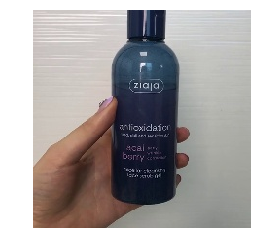

In [7]:
# opencv -> BGR, 
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# 0-255 3 channel
inputs = torch.Tensor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# H*W*C -> C*H*W
inputs = inputs.transpose(1,2).transpose(0,1).unsqueeze(0).to(device)
# inputs.shape
outputs = model(inputs)

outputs.view(-1,2048)

tensor([[ 62.4627,  12.3657,   2.3434,  ...,  85.0342, 138.7680,  16.8278]],
       device='cuda:0')

In [562]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [9]:
# 0-255 3 channel
# BGR -> RGB
inputs = torch.Tensor(img[:,:,::-1].copy())
# H*W*C -> C*H*W
inputs = inputs.transpose(1,2).transpose(0,1).unsqueeze(0).to(device)
# inputs.shape
outputs = model(inputs)

outputs.view(-1,2048)

tensor([[ 62.4627,  12.3657,   2.3434,  ...,  85.0342, 138.7680,  16.8278]],
       device='cuda:0')

In [10]:
import torchvision

# RGB 0~1 scaling
def load_dataset():
    data_path = imgPath
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False
    )
    return train_loader

# for batch_idx, (data, target) in enumerate(load_dataset()):
    #train network

In [124]:
data_path = imgPath
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)
dd=iter(train_loader)

In [125]:
train_dataset.class_to_idx

{'ACAI BERRY-MICELLAR CLEANSING FACE SCRUB GEL': 0,
 'ACNES-CLEAR_WHITE FOAMING WASH': 1,
 'ACNES-DERMA RELIEF ESSENCE LOTION': 2,
 'AGE20_S-ESSENCE COVER FACT VX': 3,
 'AHC-AGELESS REAL EYE CREAM FOR FACE': 4,
 'AHC-REAL SYNERGY OIL': 5,
 'ALOE VERA-ALOE MOISTURIZING BRIGHT CARE': 6,
 'APIEU-POWER BLOCK SUN BASE': 7,
 'AQUAXL-MAKE UP FOR EVER': 8,
 'ARITAUM-MONO EYES': 9,
 'ATOMY-EVENING CARE PEELING GEL': 10,
 'A_PIEU-MINERAL MONO SHADOW': 11,
 'A_PIEU-POWER BLOCK SUN BASE': 12,
 'BANANABOAT-ALOE VERA GEL': 13,
 'BATH_BODY WORKS-HELLO BEAUTIFUL ULTRA SHEA BODY CREAM': 14,
 'BELIF-BELIEVE IN TRUTH CREAM': 15,
 'BELIF-BERGAMOT HERBAL EXTRACT TONER': 16,
 'BELIF-CREAMY MOISTURIZER DEEP MOIST': 17,
 'BELIF-MANOLOGY MOISTURIZER AQUA BOMB': 18,
 'BELIF-STRESS SHOOTER CICA BOMB CREAM': 19,
 'BELIF-UV PROTECTOR DAILY SUNSCREEN GEL': 20,
 'BENEFIC-CHA CHA TINT': 21,
 'BENEFIC-SUGARBOMB': 22,
 'BENEFIT-DANDELION': 23,
 'BEYOND-ANGEL AQUA DAILY BIG TONER': 24,
 'BEYOND-DISNEY ECO CREAM': 25,
 '

In [126]:
data, target = dd.next()
target

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

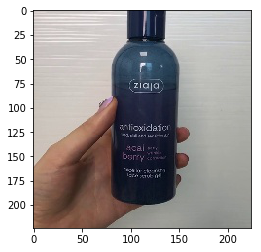

In [13]:
ii = data[0].transpose(0,1).transpose(1,2)
plt.imshow(ii)
plt.show()

In [234]:
# inputs.shape
outputs = model(data[:64,:].to(device))
outputs = outputs.view(-1,2048)

In [15]:
# 
temp = []
for batch_idx, (data, target) in enumerate(load_dataset()):
    outputs = model(data.to(device))
    outputs = outputs.view(-1,2048)
    temp.append(outputs)


res = torch.cat(temp, dim=0)
res.shape

torch.Size([6306, 2048])

In [21]:
%%time
#tsne
each = 1000
from sklearn.manifold import TSNE

tsne_model = TSNE(learning_rate=100)
transformed = tsne_model.fit_transform(res[0:each].cpu())

Wall time: 844 ms


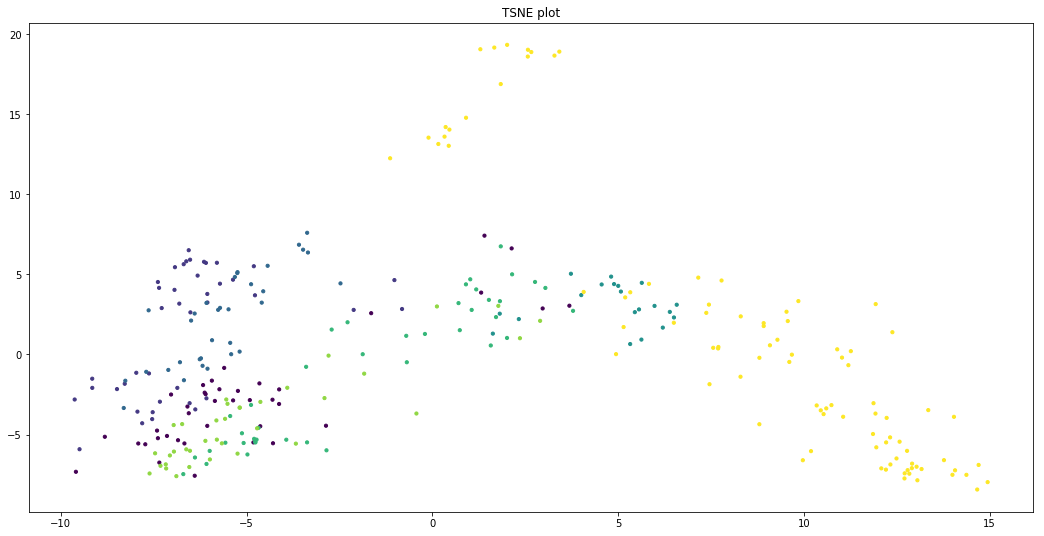

In [514]:
xs = transformed[:each,0]
ys = transformed[:each,1]
plt.figure(figsize=(18,9))
scatter = plt.scatter(xs,ys, s=10, c=train_dataset.targets[:each])
# scatter = plt.scatter(ttt[:,0], ttt[:,1], s=100, c='r')
plt.title("TSNE plot")
plt.show()

In [543]:
%%time
from sklearn.decomposition import PCA

each = 406
pca = PCA(n_components=16) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
transformed = pca.fit_transform(res[0:each].cpu())

Wall time: 66 ms


In [544]:
df2 = pd.DataFrame(transformed[:,:2], columns=['x1', 'x2'])
df2['label'] = train_dataset.targets[:each]
df2

,x1,x2,label
0,-5.009534,-8.231190,0
1,-2.843783,-6.174317,0
2,-3.648169,-5.249868,0
3,-4.638408,-6.148155,0
4,-4.313550,-5.425215,0
5,-4.766513,-5.623824,0
6,-3.656322,-5.741825,0
7,-5.394442,-5.284880,0
8,-4.875127,-5.634212,0
9,-4.928878,-4.738308,0


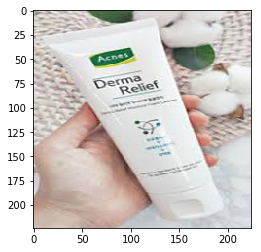

In [545]:
testImgPath = ".\\ttt4.jpg"
img = cv2.imread(os.path.join(testImgPath), cv2.IMREAD_COLOR)
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
# 0-255 3 channel
inputs = torch.Tensor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))/255
plt.imshow(inputs)
plt.show()
# H*W*C -> C*H*W
inputs = inputs.transpose(1,2).transpose(0,1).unsqueeze(0).to(device)
# inputs.shape
outputs = model(inputs)

ttt = pca.transform(outputs.view(-1,2048).cpu())

In [546]:
ttt

array([[-1.18268814, -9.10718405,  2.28032673,  0.04294501, 14.04930553,
        -3.54270363,  0.06843564, -4.47834808,  4.70974587,  0.12088024,
        -0.4965323 , -3.15778496, -2.688204  , -3.35586235, -1.4039676 ,
        -1.5517925 ]])

---
## multivariate gaussian

In [547]:
%%time
from torch.distributions.multivariate_normal import MultivariateNormal

gaussian_models = {}
for i in set(df2['label']):
    print('label:', i, ', each:', sum(df2['label'] == i))
    data_labeled = transformed[df2['label'] == i]
    mean = np.mean(data_labeled, axis=0)
    cov = np.cov(data_labeled, rowvar=False)
#     print('mean:',mean)
#     print('cov:', cov)
    m = MultivariateNormal(torch.tensor(mean), torch.tensor(cov))
    gaussian_models[i] = m

label: 0 , each: 39
label: 1 , each: 41
label: 2 , each: 33
label: 3 , each: 20
label: 4 , each: 41
label: 5 , each: 36
label: 6 , each: 131
label: 7 , each: 44
label: 8 , each: 21
Wall time: 69 ms


In [548]:
temp = []
for label in gaussian_models:
    # sam = gaussian_models[0].sample([10]).double()# smapling
    prob = gaussian_models[label].log_prob(torch.tensor([ttt, ttt])) # get prob
    print('label:', label, ', prob:', prob.data)
    temp.append(prob.data)
res_prob = torch.cat(temp, dim=1)
print(res_prob.max(dim=1))
indices = res_prob.max(dim=1).indices

label: 0 , prob: tensor([[-531.6858],
        [-531.6858]], dtype=torch.float64)
label: 1 , prob: tensor([[-350.3845],
        [-350.3845]], dtype=torch.float64)
label: 2 , prob: tensor([[-615.7730],
        [-615.7730]], dtype=torch.float64)
label: 3 , prob: tensor([[-1263.6661],
        [-1263.6661]], dtype=torch.float64)
label: 4 , prob: tensor([[-665.5017],
        [-665.5017]], dtype=torch.float64)
label: 5 , prob: tensor([[-957.2064],
        [-957.2064]], dtype=torch.float64)
label: 6 , prob: tensor([[-186.1335],
        [-186.1335]], dtype=torch.float64)
label: 7 , prob: tensor([[-206.7082],
        [-206.7082]], dtype=torch.float64)
label: 8 , prob: tensor([[-3201.2193],
        [-3201.2193]], dtype=torch.float64)
torch.return_types.max(
values=tensor([-186.1335, -186.1335], dtype=torch.float64),
indices=tensor([6, 6]))


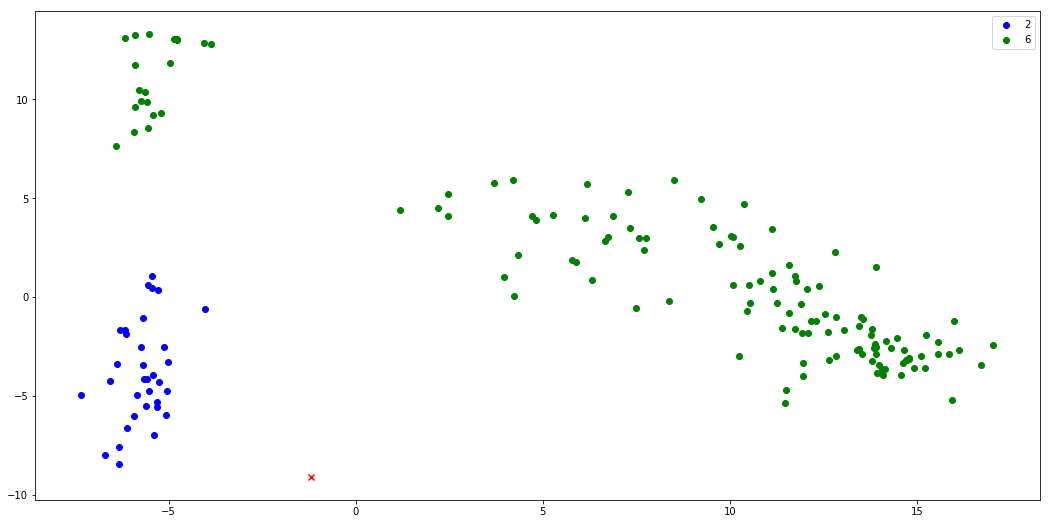

In [549]:
plt.figure(figsize=(18,9))

truth = 2
data_labeled_truth = transformed[df2['label'] == truth]
data_labeled_predicted = transformed[df2['label'] == indices.numpy()[0]]

plt.scatter(ttt[:,0], ttt[:,1], marker='x', c='r')
plt.scatter(data_labeled_truth[:,0], data_labeled_truth[:,1], marker='o', c='b', label=truth)
plt.scatter(data_labeled_predicted[:,0], data_labeled_predicted[:,1], marker='o', c='g', label=indices.numpy()[0])
plt.legend()
plt.show()

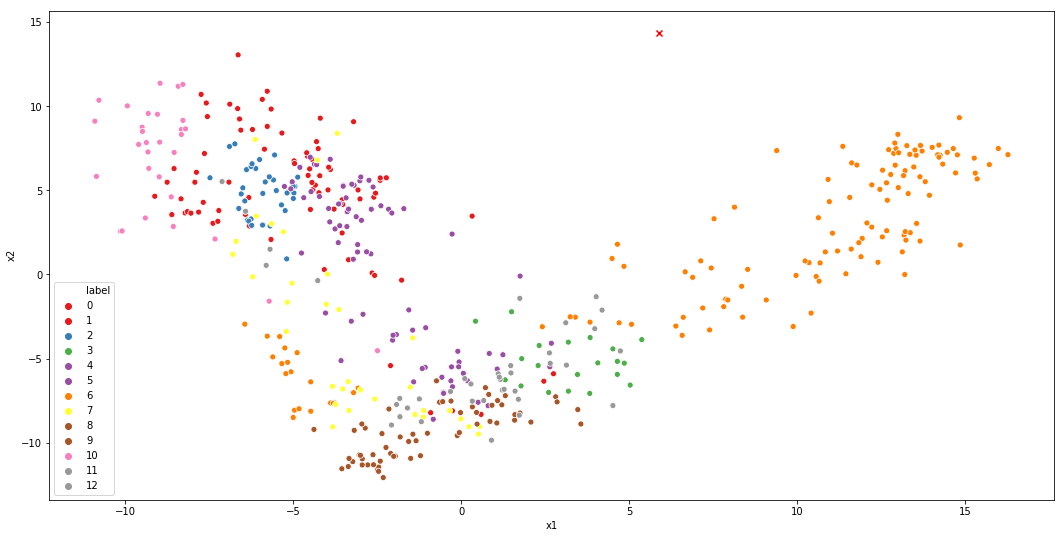

In [529]:
import seaborn as sns
plt.figure(figsize=(18,9))

plt.scatter(ttt[:,0], ttt[:,1], marker='x', c='r')
ax = sns.scatterplot(x='x1', y='x2', hue='label', data=df2, palette="Set1", legend="full")
plt.show()

---
# DEPRECATED

In [ ]:
temp = []
for d in df['videoName']:
    try:
        ext = d.split('.')[-1]
        n = '.'.join(d.split('.')[:-1])
        p = os.path.join(".\\img", n)
        if len(os.listdir(p))==0: temp.append(os.path.join(".\\video\\resized", d))
    except: #ext 에러난걳
        print(p)
        temp.append(os.path.join(".\\video\\resized", d))
                    
print(len(temp))
temp

# 한글 빠진거 수정용
errors = []
for idx in tqdm(range(len(temp))):
# 비디오 전처리
#         videoPath = temp[idx]
#         allData, mergedAreas = preprocessVideo(videoPath,  OPT_SHOW_IMAGE = False)
#         # 통계량 추출
#         upperBound, lowerBound, diff_ratio_mean, diff_ratio_median, referenceAllData = getStatistics(allData, mergedAreas, showPlot=False)
#         # 이미지 추출
#         extractImages(videoPath, allData, upperBound, lowerBound, diff_ratio_median, referenceAllData, OPT_SHOW_IMAGE2 = False)
        
    try:
#         # 비디오 리사이징
#         videoPath, videoWidth, videoHeight, videoLength = resizeVideo(df, idx, resizedDirPath)
        # 비디오 전처리
        videoPath = temp[idx]
        videoLength, videoWidth, videoHeight, _ = get_video_info(videoPath)
        allData, mergedAreas = preprocessVideo(videoPath,  OPT_SHOW_IMAGE = False)
        # 통계량 추출
        upperBound, lowerBound, diff_ratio_mean, diff_ratio_median, referenceAllData = getStatistics(allData, mergedAreas, showPlot=False)
        # 이미지 추출
        extractImages(videoPath, allData, upperBound, lowerBound, diff_ratio_median, referenceAllData, OPT_SHOW_IMAGE2 = False)
    except:
        print("[Error occured]:", idx, videoPath)
        errors.append([idx, videoPath])